In [131]:
import pandas as pd
import pypsa
import numpy as np
import matplotlib.pyplot as plt

# Load Data

In [132]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime

# load onshore wind data
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)

# load offshore wind data
df_offshorewind = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshorewind.index = pd.to_datetime(df_offshorewind.index)

# load large scale pv data
df_pv = pd.read_csv('data\pv_optimal.csv', sep=';', index_col=0)
df_pv.index = pd.to_datetime(df_pv.index)

# load rooftop pv data
df_rooftop = pd.read_csv('data\pv_rooftop.csv', sep=';', index_col=0)
df_rooftop.index = pd.to_datetime(df_rooftop.index)

# load hydro inflow in Austria
df_hydro = pd.read_csv('data/Hydro_Inflow_AT.csv')  # assumes columns: Year, Month, Day, Inflow [GWh]
df_hydro['date'] = pd.to_datetime(df_hydro[['Year', 'Month', 'Day']])
df_hydro.set_index('date', inplace=True)

# Convert from GWh/day → MW (spread evenly across 24 hours)
df_hydro['inflow_MW'] = df_hydro['Inflow [GWh]'] * 1000 / 24
## Align to model snapshots
df_hydro_hourly = df_hydro['inflow_MW'].resample('H').ffill()


hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

df_hydro_inflow = pd.DataFrame(index=hours_in_2015)
df_hydro_inflow['inflow_MW'] = df_hydro_hourly.loc[df_hydro_hourly.index.year==2011].values

<>:14: DeprecationWarning: invalid escape sequence '\p'
<>:18: DeprecationWarning: invalid escape sequence '\p'
<>:14: DeprecationWarning: invalid escape sequence '\p'
<>:18: DeprecationWarning: invalid escape sequence '\p'
C:\Users\alexk\AppData\Local\Temp\ipykernel_25344\3096401804.py:14: DeprecationWarning: invalid escape sequence '\p'
  df_pv = pd.read_csv('data\pv_optimal.csv', sep=';', index_col=0)
C:\Users\alexk\AppData\Local\Temp\ipykernel_25344\3096401804.py:18: DeprecationWarning: invalid escape sequence '\p'
  df_rooftop = pd.read_csv('data\pv_rooftop.csv', sep=';', index_col=0)
C:\Users\alexk\AppData\Local\Temp\ipykernel_25344\3096401804.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hydro_hourly = df_hydro['inflow_MW'].resample('H').ffill()


In [133]:
colors = {"onshore": "blue", "offshore": "darkblue", "pv": "orange", 
          "rooftop": "yellow", "coal": "brown", "OCGT": "grey"}

# __F.__ Make Network

In [134]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [135]:
n = pypsa.Network()
n.set_snapshots(hours_in_2015.values)

# add the different carriers, only gas emits CO2
n.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
n.add("Carrier", "coal", co2_emissions=0.9) # in t_CO2/MWh_th
n.add("Carrier", "onshorewind")
n.add("Carrier", "offshorewind")
n.add("Carrier", "solarPV")
n.add("Carrier", "rooftopPV")
n.add("Carrier", "hydro")

countries = ['DEU', 'DNK', 'AUT']
coordinates = {'DNK': (55.67, 12.57), # Copenhagen
                'DEU': (52.37, 9.73), # Hannover
                'AUT': (47.57, 14.23)} # Liezen

# add electricity bus
for country in countries:
    n.add("Bus",
                country,
                y = coordinates[country][0],
                x = coordinates[country][1],
                carrier="AC",)

    # add load to the bus
    n.add("Load",
                f"load{country}",
                bus=country,
                p_set=df_elec[country].values)


    ''' Add renewable generators '''
    if country != 'AUT':
        # Add onshore wind
        CF_wind_onshore = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
        lifetime = 30 # years
        discount_rate = 0.07 # 7%
        capex = 910000 # in €/MW
        fopex = 0.033 # 3.3% of capex
        capital_cost_onshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        n.add("Generator",
                    f"onshorewind{country}",
                    bus=country,
                    p_nom_extendable=True,
                    carrier="onshorewind",
                    #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                    capital_cost = capital_cost_onshorewind,
                    marginal_cost = 0,
                    p_max_pu = CF_wind_onshore.values)

        # Add offshore wind
        CF_wind_offshore = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
        lifetime = 25 # years
        discount_rate = 0.07 # 7%
        capex = 2506000 # in €/MW
        fopex = 0.03 # 3% of capex
        capital_cost_offshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        n.add("Generator",
                    f"offshorewind{country}",
                    bus=country,
                    p_nom_extendable=True,
                    carrier="offshorewind",
                    #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                    capital_cost = capital_cost_offshorewind,
                    marginal_cost = 0,
                    p_max_pu = CF_wind_offshore.values)

    # Add large scale solar
    CF_solar = df_pv[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    lifetime = 25 # years
    discount_rate = 0.07 # 7%
    capex = 425000 # in €/MW
    fopex = 0.03 # 3% of capex
    capital_cost_pv = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
    n.add("Generator",
                f"PV{country}",
                bus=country,
                p_nom_extendable=True,
                carrier="solarPV",
                #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                capital_cost = capital_cost_pv,
                marginal_cost = 0,
                p_max_pu = CF_solar.values)



    ''' Add non-renewables generators '''
    # add OCGT (Open Cycle Gas Turbine) generator
    lifetime = 25 # years
    discount_rate = 0.07 # 7%
    capex = 560000 # in €/MW
    fopex = 0.033 # 3.3% of capex
    capital_cost_OCGT = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
    fuel_cost = 21.6 # in €/MWh_th
    efficiency = 0.39 # MWh_elec/MWh_th
    marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
    n.add("Generator",
                f"OCGT{country}",
                bus=country,
                p_nom_extendable=True,
                carrier="gas",
                #p_nom_max=1000,
                capital_cost = capital_cost_OCGT,
                efficiency = efficiency,
                marginal_cost = marginal_cost_OCGT)

    if country == 'DEU':
        # add coal generator (without CCS) # https://atb-archive.nrel.gov/electricity/2018/index.html?t=cc
        lifetime = 25 # years
        discount_rate = 0.07 # 7%
        capex = 3294000 # in €/MW
        fopex = 0.03 # 3% of capex
        capital_cost_coal = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        fuel_cost = 4 # in €/MWh_th 
        efficiency = 0.36 # MWh_elec/MWh_th
        marginal_cost_coal = fuel_cost/efficiency # in €/MWh_el
        n.add("Generator",
                    f"coal{country}",
                    bus=country,
                    p_nom_extendable=True,
                    carrier="coal",
                    #p_nom_max=1000,
                    capital_cost = capital_cost_coal,
                    efficiency = efficiency,
                    marginal_cost = marginal_cost_coal)
        
    if country == 'AUT':
        lifetime = 80 # years
        discount_rate = 0.07 # 7%
        capex = 300000 # in €/MW
        fopex = 0.02 # 2% of capex
        capital_cost_hydro = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
        marginal_cost_hydro = 0

        n.add("StorageUnit",
            name=f"hydro{country}",
            bus=country,
            p_nom_extendable=True,
            capital_cost=capital_cost_hydro,
            marginal_cost=0,
            efficiency_store=1.0,       # inflow enters fully
            efficiency_dispatch=0.9,    # turbine efficiency
            max_hours=2000,             # max energy storage in MWh per MW of power capacity
            inflow=df_hydro_inflow.values.flatten(),  # energy inflow time series in MW
            carrier="hydro")


    # Add storage unit
    n.add("StorageUnit",
                f"battery{country}",
                bus=country,
                p_nom_extendable=True,
                capital_cost=12894+24678,
                efficiency_dispatch=0.96,
                efficiency_store=0.96,
                max_hours=2,
                cyclic_state_of_charge=True)
    




In [136]:
# Add AC lines between the countries
distances = {
    ("DEU", "DNK"): 406, # km
    ("DEU", "AUT"): 622, # km
    ("DNK", "AUT"): 909, # km
}

capital_cost_lines = 400 # in €/MW/km

n.add(
    "Line",
    "DEU-DNK",
    bus0="DEU",
    bus1="DNK",
    s_nom = 2500,
    x = 1,
    r = 1,
    #capital_cost = capital_cost_lines * distances[("DEU", "DNK")],
    #s_nom_extendable = True
)

n.add(
    "Line",
    "DEU-AUT",
    bus0="DEU",
    bus1="AUT",
    s_nom = 6500,
    x = 1,
    r = 1,
    #capital_cost = capital_cost_lines * distances[("DEU", "AUT")],
    #s_nom_extendable = True
)

'''
n.add(
    "Line",
    "DNK-AUT",
    bus0="DNK",
    bus1="AUT",
    s_nom = 300,
    x = 1,
    r = 1,
    #capital_cost = capital_cost_lines * distances[("DNK", "AUT")],
    #s_nom_extendable = True
)
'''

'\nn.add(\n    "Line",\n    "DNK-AUT",\n    bus0="DNK",\n    bus1="AUT",\n    s_nom = 300,\n    x = 1,\n    r = 1,\n    #capital_cost = capital_cost_lines * distances[("DNK", "AUT")],\n    #s_nom_extendable = True\n)\n'

In [137]:
n.lines

,bus0,bus1,type,x,r,g,b,s_nom,s_nom_mod,s_nom_extendable,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,
DEU-DNK,DEU,DNK,,1.0,1.0,0.0,0.0,2500.0,0.0,False,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DEU-AUT,DEU,AUT,,1.0,1.0,0.0,0.0,6500.0,0.0,False,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


c:\Users\alexk\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


(<matplotlib.collections.PatchCollection at 0x27a01cf5150>,
 <matplotlib.collections.LineCollection at 0x27a1ce5e950>)

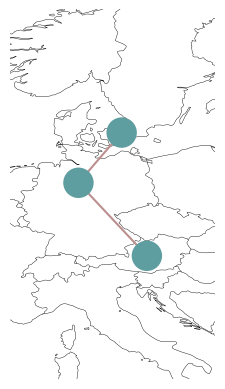

In [138]:
n.plot(bus_sizes=1, margin=1)

In [139]:

# Co2 Cap
CO2_limit = (152 + 4.9 + 6.0) #MtCO2 just electricity

n.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant= CO2_limit * 1000000, #152MtCO2 for GE + 6.0 for DK (https://www.nowtricity.com/country/denmark/) + 4.9 for AT (https://www.nowtricity.com/country/austria)
)


Index(['CO2Limit'], dtype='object')

In [140]:
n.optimize(solver_name='gurobi')


Index(['DEU', 'DNK', 'AUT'], dtype='object', name='Bus')
Index(['DEU-DNK', 'DEU-AUT'], dtype='object', name='Line')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.01it/s]
INFO:linopy.io: Writing time: 3.42s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-buwdd26s.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-buwdd26s.lp


Reading time = 1.14 seconds


INFO:gurobipy:Reading time = 1.14 seconds


obj: 499336 rows, 227775 columns, 1012000 nonzeros


INFO:gurobipy:obj: 499336 rows, 227775 columns, 1012000 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 499336 rows, 227775 columns and 1012000 nonzeros


INFO:gurobipy:Optimize a model with 499336 rows, 227775 columns and 1012000 nonzeros


Model fingerprint: 0xa45e9cb0


INFO:gurobipy:Model fingerprint: 0xa45e9cb0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+03]


INFO:gurobipy:  Matrix range     [1e-03, 2e+03]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [1e+03, 6e+03]


INFO:gurobipy:  Bounds range     [1e+03, 6e+03]


  RHS range        [1e+03, 2e+08]


INFO:gurobipy:  RHS range        [1e+03, 2e+08]


Presolve removed 249469 rows and 12934 columns


INFO:gurobipy:Presolve removed 249469 rows and 12934 columns


Presolve time: 0.75s


INFO:gurobipy:Presolve time: 0.75s


Presolved: 249867 rows, 214841 columns, 749597 nonzeros


INFO:gurobipy:Presolved: 249867 rows, 214841 columns, 749597 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.24s


INFO:gurobipy:Ordering time: 0.24s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 15


INFO:gurobipy: Dense cols : 15


 AA' NZ     : 6.311e+05


INFO:gurobipy: AA' NZ     : 6.311e+05


 Factor NZ  : 4.485e+06 (roughly 220 MB of memory)


INFO:gurobipy: Factor NZ  : 4.485e+06 (roughly 220 MB of memory)


 Factor Ops : 9.751e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 9.751e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.05020884e+13 -4.54097143e+11  5.10e+10 0.00e+00  4.60e+09     2s


INFO:gurobipy:   0   1.05020884e+13 -4.54097143e+11  5.10e+10 0.00e+00  4.60e+09     2s


   1   1.36058692e+13 -1.55555053e+12  9.77e+09 3.20e+02  1.05e+09     2s


INFO:gurobipy:   1   1.36058692e+13 -1.55555053e+12  9.77e+09 3.20e+02  1.05e+09     2s


   2   1.10062055e+13 -1.55782459e+12  1.31e+09 6.89e+01  2.26e+08     2s


INFO:gurobipy:   2   1.10062055e+13 -1.55782459e+12  1.31e+09 6.89e+01  2.26e+08     2s


   3   4.47210853e+12 -8.74253439e+11  1.11e+08 8.32e+00  3.38e+07     3s


INFO:gurobipy:   3   4.47210853e+12 -8.74253439e+11  1.11e+08 8.32e+00  3.38e+07     3s


   4   2.07321038e+12 -2.91054862e+11  2.84e+07 1.18e+00  8.01e+06     3s


INFO:gurobipy:   4   2.07321038e+12 -2.91054862e+11  2.84e+07 1.18e+00  8.01e+06     3s


   5   8.31650308e+11 -6.34010708e+10  7.54e+06 1.42e-01  2.36e+06     4s


INFO:gurobipy:   5   8.31650308e+11 -6.34010708e+10  7.54e+06 1.42e-01  2.36e+06     4s


   6   2.56411368e+11 -1.36310689e+10  1.71e+06 3.54e-02  6.68e+05     4s


INFO:gurobipy:   6   2.56411368e+11 -1.36310689e+10  1.71e+06 3.54e-02  6.68e+05     4s


   7   1.33270299e+11  2.61250494e+09  7.32e+05 1.68e-02  3.16e+05     5s


INFO:gurobipy:   7   1.33270299e+11  2.61250494e+09  7.32e+05 1.68e-02  3.16e+05     5s


   8   9.07978950e+10  1.12293919e+10  4.12e+05 8.99e-03  1.90e+05     5s


INFO:gurobipy:   8   9.07978950e+10  1.12293919e+10  4.12e+05 8.99e-03  1.90e+05     5s


   9   6.84191456e+10  1.59629983e+10  2.64e+05 5.49e-03  1.25e+05     5s


INFO:gurobipy:   9   6.84191456e+10  1.59629983e+10  2.64e+05 5.49e-03  1.25e+05     5s


  10   5.53711728e+10  1.99287925e+10  1.79e+05 2.92e-03  8.37e+04     5s


INFO:gurobipy:  10   5.53711728e+10  1.99287925e+10  1.79e+05 2.92e-03  8.37e+04     5s


  11   4.85372771e+10  2.25328865e+10  1.33e+05 1.52e-03  6.12e+04     6s


INFO:gurobipy:  11   4.85372771e+10  2.25328865e+10  1.33e+05 1.52e-03  6.12e+04     6s


  12   4.18632912e+10  2.47658059e+10  8.65e+04 5.90e-04  4.01e+04     6s


INFO:gurobipy:  12   4.18632912e+10  2.47658059e+10  8.65e+04 5.90e-04  4.01e+04     6s


  13   3.82876015e+10  2.61859923e+10  6.16e+04 1.90e-04  2.84e+04     7s


INFO:gurobipy:  13   3.82876015e+10  2.61859923e+10  6.16e+04 1.90e-04  2.84e+04     7s


  14   3.55434174e+10  2.72882964e+10  4.13e+04 4.80e-10  1.93e+04     7s


INFO:gurobipy:  14   3.55434174e+10  2.72882964e+10  4.13e+04 4.80e-10  1.93e+04     7s


  15   3.52155827e+10  2.76853838e+10  3.87e+04 1.00e-09  1.76e+04     7s


INFO:gurobipy:  15   3.52155827e+10  2.76853838e+10  3.87e+04 1.00e-09  1.76e+04     7s


  16   3.49319156e+10  2.82063524e+10  3.66e+04 2.90e-09  1.57e+04     8s


INFO:gurobipy:  16   3.49319156e+10  2.82063524e+10  3.66e+04 2.90e-09  1.57e+04     8s


  17   3.35686172e+10  2.84880479e+10  2.66e+04 2.80e-09  1.19e+04     8s


INFO:gurobipy:  17   3.35686172e+10  2.84880479e+10  2.66e+04 2.80e-09  1.19e+04     8s


  18   3.28142061e+10  2.85214761e+10  2.09e+04 3.05e-10  1.00e+04     8s


INFO:gurobipy:  18   3.28142061e+10  2.85214761e+10  2.09e+04 3.05e-10  1.00e+04     8s


  19   3.25862698e+10  2.86465418e+10  1.92e+04 2.80e-09  9.22e+03     9s


INFO:gurobipy:  19   3.25862698e+10  2.86465418e+10  1.92e+04 2.80e-09  9.22e+03     9s


  20   3.23981544e+10  2.88562401e+10  1.79e+04 9.16e-10  8.28e+03     9s


INFO:gurobipy:  20   3.23981544e+10  2.88562401e+10  1.79e+04 9.16e-10  8.28e+03     9s


  21   3.21449813e+10  2.90098870e+10  1.61e+04 2.39e-09  7.33e+03    10s


INFO:gurobipy:  21   3.21449813e+10  2.90098870e+10  1.61e+04 2.39e-09  7.33e+03    10s


  22   3.20405547e+10  2.90992013e+10  1.52e+04 2.14e-09  6.88e+03    10s


INFO:gurobipy:  22   3.20405547e+10  2.90992013e+10  1.52e+04 2.14e-09  6.88e+03    10s


  23   3.18398890e+10  2.92898752e+10  1.36e+04 4.20e-09  5.96e+03    11s


INFO:gurobipy:  23   3.18398890e+10  2.92898752e+10  1.36e+04 4.20e-09  5.96e+03    11s


  24   3.15941535e+10  2.93812129e+10  1.13e+04 3.93e-09  5.17e+03    11s


INFO:gurobipy:  24   3.15941535e+10  2.93812129e+10  1.13e+04 3.93e-09  5.17e+03    11s


  25   3.12103887e+10  2.95418397e+10  7.84e+03 5.54e-09  3.90e+03    11s


INFO:gurobipy:  25   3.12103887e+10  2.95418397e+10  7.84e+03 5.54e-09  3.90e+03    11s


  26   3.10202180e+10  2.96534220e+10  6.32e+03 1.54e-08  3.20e+03    12s


INFO:gurobipy:  26   3.10202180e+10  2.96534220e+10  6.32e+03 1.54e-08  3.20e+03    12s


  27   3.09072764e+10  2.97253973e+10  5.19e+03 1.69e-08  2.76e+03    12s


INFO:gurobipy:  27   3.09072764e+10  2.97253973e+10  5.19e+03 1.69e-08  2.76e+03    12s


  28   3.07280670e+10  2.98456575e+10  3.55e+03 1.91e-08  2.06e+03    13s


INFO:gurobipy:  28   3.07280670e+10  2.98456575e+10  3.55e+03 1.91e-08  2.06e+03    13s


  29   3.06595248e+10  2.98940617e+10  3.01e+03 2.18e-08  1.79e+03    13s


INFO:gurobipy:  29   3.06595248e+10  2.98940617e+10  3.01e+03 2.18e-08  1.79e+03    13s


  30   3.06231036e+10  2.99529608e+10  2.74e+03 2.12e-08  1.57e+03    14s


INFO:gurobipy:  30   3.06231036e+10  2.99529608e+10  2.74e+03 2.12e-08  1.57e+03    14s


  31   3.05551962e+10  2.99774791e+10  2.20e+03 2.10e-08  1.35e+03    14s


INFO:gurobipy:  31   3.05551962e+10  2.99774791e+10  2.20e+03 2.10e-08  1.35e+03    14s


  32   3.05248875e+10  3.00081943e+10  1.94e+03 2.00e-08  1.21e+03    15s


INFO:gurobipy:  32   3.05248875e+10  3.00081943e+10  1.94e+03 2.00e-08  1.21e+03    15s


  33   3.05019805e+10  3.00281544e+10  1.72e+03 1.98e-08  1.11e+03    15s


INFO:gurobipy:  33   3.05019805e+10  3.00281544e+10  1.72e+03 1.98e-08  1.11e+03    15s


  34   3.04437887e+10  3.00711646e+10  1.18e+03 1.87e-08  8.71e+02    15s


INFO:gurobipy:  34   3.04437887e+10  3.00711646e+10  1.18e+03 1.87e-08  8.71e+02    15s


  35   3.04275524e+10  3.01283814e+10  1.04e+03 1.55e-08  7.00e+02    16s


INFO:gurobipy:  35   3.04275524e+10  3.01283814e+10  1.04e+03 1.55e-08  7.00e+02    16s


  36   3.03994163e+10  3.01455243e+10  8.25e+02 1.53e-08  5.94e+02    16s


INFO:gurobipy:  36   3.03994163e+10  3.01455243e+10  8.25e+02 1.53e-08  5.94e+02    16s


  37   3.03842872e+10  3.01776210e+10  7.15e+02 2.27e-08  4.83e+02    17s


INFO:gurobipy:  37   3.03842872e+10  3.01776210e+10  7.15e+02 2.27e-08  4.83e+02    17s


  38   3.03778459e+10  3.01936742e+10  6.65e+02 2.51e-08  4.31e+02    17s


INFO:gurobipy:  38   3.03778459e+10  3.01936742e+10  6.65e+02 2.51e-08  4.31e+02    17s


  39   3.03666313e+10  3.02021512e+10  5.66e+02 2.41e-08  3.85e+02    17s


INFO:gurobipy:  39   3.03666313e+10  3.02021512e+10  5.66e+02 2.41e-08  3.85e+02    17s


  40   3.03564694e+10  3.02178255e+10  4.81e+02 2.62e-08  3.24e+02    18s


INFO:gurobipy:  40   3.03564694e+10  3.02178255e+10  4.81e+02 2.62e-08  3.24e+02    18s


  41   3.03475640e+10  3.02238571e+10  4.13e+02 2.47e-08  2.89e+02    18s


INFO:gurobipy:  41   3.03475640e+10  3.02238571e+10  4.13e+02 2.47e-08  2.89e+02    18s


  42   3.03383287e+10  3.02335674e+10  3.39e+02 2.04e-08  2.45e+02    19s


INFO:gurobipy:  42   3.03383287e+10  3.02335674e+10  3.39e+02 2.04e-08  2.45e+02    19s


  43   3.03304632e+10  3.02386238e+10  2.76e+02 1.74e-08  2.15e+02    19s


INFO:gurobipy:  43   3.03304632e+10  3.02386238e+10  2.76e+02 1.74e-08  2.15e+02    19s


  44   3.03265591e+10  3.02450488e+10  2.44e+02 1.80e-08  1.91e+02    20s


INFO:gurobipy:  44   3.03265591e+10  3.02450488e+10  2.44e+02 1.80e-08  1.91e+02    20s


  45   3.03211039e+10  3.02480756e+10  2.00e+02 1.82e-08  1.71e+02    20s


INFO:gurobipy:  45   3.03211039e+10  3.02480756e+10  2.00e+02 1.82e-08  1.71e+02    20s


  46   3.03183999e+10  3.02512343e+10  1.76e+02 1.68e-08  1.57e+02    20s


INFO:gurobipy:  46   3.03183999e+10  3.02512343e+10  1.76e+02 1.68e-08  1.57e+02    20s


  47   3.03139583e+10  3.02578336e+10  1.41e+02 1.29e-08  1.31e+02    21s


INFO:gurobipy:  47   3.03139583e+10  3.02578336e+10  1.41e+02 1.29e-08  1.31e+02    21s


  48   3.03118043e+10  3.02596279e+10  1.24e+02 1.23e-08  1.22e+02    21s


INFO:gurobipy:  48   3.03118043e+10  3.02596279e+10  1.24e+02 1.23e-08  1.22e+02    21s


  49   3.03104439e+10  3.02643891e+10  1.13e+02 1.01e-08  1.08e+02    22s


INFO:gurobipy:  49   3.03104439e+10  3.02643891e+10  1.13e+02 1.01e-08  1.08e+02    22s


  50   3.03093009e+10  3.02694354e+10  1.04e+02 1.56e-08  9.32e+01    22s


INFO:gurobipy:  50   3.03093009e+10  3.02694354e+10  1.04e+02 1.56e-08  9.32e+01    22s


  51   3.03083160e+10  3.02720190e+10  9.64e+01 1.45e-08  8.49e+01    22s


INFO:gurobipy:  51   3.03083160e+10  3.02720190e+10  9.64e+01 1.45e-08  8.49e+01    22s


  52   3.03076933e+10  3.02728915e+10  9.18e+01 1.47e-08  8.14e+01    23s


INFO:gurobipy:  52   3.03076933e+10  3.02728915e+10  9.18e+01 1.47e-08  8.14e+01    23s


  53   3.03062597e+10  3.02762571e+10  8.13e+01 1.75e-08  7.02e+01    23s


INFO:gurobipy:  53   3.03062597e+10  3.02762571e+10  8.13e+01 1.75e-08  7.02e+01    23s


  54   3.03054636e+10  3.02796755e+10  7.53e+01 2.21e-08  6.03e+01    23s


INFO:gurobipy:  54   3.03054636e+10  3.02796755e+10  7.53e+01 2.21e-08  6.03e+01    23s


  55   3.03048891e+10  3.02805527e+10  7.12e+01 3.08e-08  5.69e+01    24s


INFO:gurobipy:  55   3.03048891e+10  3.02805527e+10  7.12e+01 3.08e-08  5.69e+01    24s


  56   3.03041292e+10  3.02814818e+10  6.58e+01 2.93e-08  5.30e+01    24s


INFO:gurobipy:  56   3.03041292e+10  3.02814818e+10  6.58e+01 2.93e-08  5.30e+01    24s


  57   3.03037912e+10  3.02816411e+10  6.31e+01 3.01e-08  5.18e+01    25s


INFO:gurobipy:  57   3.03037912e+10  3.02816411e+10  6.31e+01 3.01e-08  5.18e+01    25s


  58   3.03032271e+10  3.02828550e+10  5.89e+01 3.25e-08  4.76e+01    25s


INFO:gurobipy:  58   3.03032271e+10  3.02828550e+10  5.89e+01 3.25e-08  4.76e+01    25s


  59   3.03021350e+10  3.02839457e+10  5.06e+01 2.95e-08  4.25e+01    25s


INFO:gurobipy:  59   3.03021350e+10  3.02839457e+10  5.06e+01 2.95e-08  4.25e+01    25s


  60   3.03015752e+10  3.02848448e+10  4.66e+01 2.87e-08  3.91e+01    26s


INFO:gurobipy:  60   3.03015752e+10  3.02848448e+10  4.66e+01 2.87e-08  3.91e+01    26s


  61   3.03012074e+10  3.02855218e+10  4.37e+01 3.24e-08  3.67e+01    26s


INFO:gurobipy:  61   3.03012074e+10  3.02855218e+10  4.37e+01 3.24e-08  3.67e+01    26s


  62   3.03006290e+10  3.02862679e+10  3.96e+01 3.58e-08  3.36e+01    27s


INFO:gurobipy:  62   3.03006290e+10  3.02862679e+10  3.96e+01 3.58e-08  3.36e+01    27s


  63   3.03001635e+10  3.02875389e+10  3.63e+01 4.48e-08  2.95e+01    27s


INFO:gurobipy:  63   3.03001635e+10  3.02875389e+10  3.63e+01 4.48e-08  2.95e+01    27s


  64   3.02997823e+10  3.02885124e+10  3.33e+01 4.42e-08  2.64e+01    27s


INFO:gurobipy:  64   3.02997823e+10  3.02885124e+10  3.33e+01 4.42e-08  2.64e+01    27s


  65   3.02995656e+10  3.02886562e+10  3.16e+01 4.71e-08  2.55e+01    28s


INFO:gurobipy:  65   3.02995656e+10  3.02886562e+10  3.16e+01 4.71e-08  2.55e+01    28s


  66   3.02990054e+10  3.02891815e+10  2.71e+01 6.98e-08  2.30e+01    28s


INFO:gurobipy:  66   3.02990054e+10  3.02891815e+10  2.71e+01 6.98e-08  2.30e+01    28s


  67   3.02987583e+10  3.02896309e+10  2.51e+01 1.17e-07  2.13e+01    28s


INFO:gurobipy:  67   3.02987583e+10  3.02896309e+10  2.51e+01 1.17e-07  2.13e+01    28s


  68   3.02982171e+10  3.02899695e+10  2.06e+01 1.05e-07  1.93e+01    29s


INFO:gurobipy:  68   3.02982171e+10  3.02899695e+10  2.06e+01 1.05e-07  1.93e+01    29s


  69   3.02978943e+10  3.02904127e+10  1.79e+01 9.97e-08  1.75e+01    29s


INFO:gurobipy:  69   3.02978943e+10  3.02904127e+10  1.79e+01 9.97e-08  1.75e+01    29s


  70   3.02977544e+10  3.02905916e+10  1.69e+01 1.08e-07  1.68e+01    30s


INFO:gurobipy:  70   3.02977544e+10  3.02905916e+10  1.69e+01 1.08e-07  1.68e+01    30s


  71   3.02975648e+10  3.02908643e+10  1.56e+01 1.23e-07  1.57e+01    30s


INFO:gurobipy:  71   3.02975648e+10  3.02908643e+10  1.56e+01 1.23e-07  1.57e+01    30s


  72   3.02973568e+10  3.02910877e+10  1.38e+01 1.57e-07  1.47e+01    30s


INFO:gurobipy:  72   3.02973568e+10  3.02910877e+10  1.38e+01 1.57e-07  1.47e+01    30s


  73   3.02972634e+10  3.02913174e+10  1.32e+01 1.64e-07  1.39e+01    31s


INFO:gurobipy:  73   3.02972634e+10  3.02913174e+10  1.32e+01 1.64e-07  1.39e+01    31s


  74   3.02971451e+10  3.02917210e+10  1.23e+01 1.89e-07  1.27e+01    31s


INFO:gurobipy:  74   3.02971451e+10  3.02917210e+10  1.23e+01 1.89e-07  1.27e+01    31s


  75   3.02970593e+10  3.02918722e+10  1.16e+01 2.21e-07  1.21e+01    32s


INFO:gurobipy:  75   3.02970593e+10  3.02918722e+10  1.16e+01 2.21e-07  1.21e+01    32s


  76   3.02969393e+10  3.02920725e+10  1.06e+01 2.14e-07  1.14e+01    32s


INFO:gurobipy:  76   3.02969393e+10  3.02920725e+10  1.06e+01 2.14e-07  1.14e+01    32s


  77   3.02968933e+10  3.02921454e+10  1.03e+01 2.16e-07  1.11e+01    32s


INFO:gurobipy:  77   3.02968933e+10  3.02921454e+10  1.03e+01 2.16e-07  1.11e+01    32s


  78   3.02967074e+10  3.02923876e+10  9.09e+00 2.59e-07  1.01e+01    33s


INFO:gurobipy:  78   3.02967074e+10  3.02923876e+10  9.09e+00 2.59e-07  1.01e+01    33s


  79   3.02966266e+10  3.02926186e+10  8.59e+00 2.41e-07  9.38e+00    33s


INFO:gurobipy:  79   3.02966266e+10  3.02926186e+10  8.59e+00 2.41e-07  9.38e+00    33s


  80   3.02965286e+10  3.02928102e+10  7.89e+00 2.41e-07  8.70e+00    34s


INFO:gurobipy:  80   3.02965286e+10  3.02928102e+10  7.89e+00 2.41e-07  8.70e+00    34s


  81   3.02964401e+10  3.02929720e+10  7.21e+00 2.31e-07  8.11e+00    34s


INFO:gurobipy:  81   3.02964401e+10  3.02929720e+10  7.21e+00 2.31e-07  8.11e+00    34s


  82   3.02963892e+10  3.02931088e+10  6.79e+00 3.34e-07  7.67e+00    34s


INFO:gurobipy:  82   3.02963892e+10  3.02931088e+10  6.79e+00 3.34e-07  7.67e+00    34s


  83   3.02963075e+10  3.02932452e+10  6.24e+00 4.39e-07  7.16e+00    35s


INFO:gurobipy:  83   3.02963075e+10  3.02932452e+10  6.24e+00 4.39e-07  7.16e+00    35s


  84   3.02962253e+10  3.02933549e+10  5.58e+00 3.96e-07  6.72e+00    35s


INFO:gurobipy:  84   3.02962253e+10  3.02933549e+10  5.58e+00 3.96e-07  6.72e+00    35s


  85   3.02961332e+10  3.02935729e+10  4.84e+00 6.74e-07  5.99e+00    35s


INFO:gurobipy:  85   3.02961332e+10  3.02935729e+10  4.84e+00 6.74e-07  5.99e+00    35s


  86   3.02960791e+10  3.02936867e+10  4.44e+00 5.97e-07  5.60e+00    36s


INFO:gurobipy:  86   3.02960791e+10  3.02936867e+10  4.44e+00 5.97e-07  5.60e+00    36s


  87   3.02960369e+10  3.02938365e+10  4.08e+00 3.11e-07  5.15e+00    36s


INFO:gurobipy:  87   3.02960369e+10  3.02938365e+10  4.08e+00 3.11e-07  5.15e+00    36s


  88   3.02959888e+10  3.02939672e+10  3.74e+00 1.58e-07  4.73e+00    37s


INFO:gurobipy:  88   3.02959888e+10  3.02939672e+10  3.74e+00 1.58e-07  4.73e+00    37s


  89   3.02959498e+10  3.02940382e+10  3.49e+00 1.55e-07  4.47e+00    37s


INFO:gurobipy:  89   3.02959498e+10  3.02940382e+10  3.49e+00 1.55e-07  4.47e+00    37s


  90   3.02959177e+10  3.02941022e+10  3.28e+00 1.80e-07  4.25e+00    37s


INFO:gurobipy:  90   3.02959177e+10  3.02941022e+10  3.28e+00 1.80e-07  4.25e+00    37s


  91   3.02959095e+10  3.02942540e+10  3.22e+00 4.07e-07  3.87e+00    38s


INFO:gurobipy:  91   3.02959095e+10  3.02942540e+10  3.22e+00 4.07e-07  3.87e+00    38s


  92   3.02958638e+10  3.02943423e+10  2.89e+00 6.07e-07  3.56e+00    38s


INFO:gurobipy:  92   3.02958638e+10  3.02943423e+10  2.89e+00 6.07e-07  3.56e+00    38s


  93   3.02958165e+10  3.02945198e+10  2.48e+00 4.80e-07  3.03e+00    39s


INFO:gurobipy:  93   3.02958165e+10  3.02945198e+10  2.48e+00 4.80e-07  3.03e+00    39s


  94   3.02958019e+10  3.02946389e+10  2.37e+00 1.48e-06  2.72e+00    39s


INFO:gurobipy:  94   3.02958019e+10  3.02946389e+10  2.37e+00 1.48e-06  2.72e+00    39s


  95   3.02957632e+10  3.02946901e+10  2.08e+00 1.90e-06  2.51e+00    39s


INFO:gurobipy:  95   3.02957632e+10  3.02946901e+10  2.08e+00 1.90e-06  2.51e+00    39s


  96   3.02957119e+10  3.02947653e+10  1.62e+00 1.47e-06  2.21e+00    40s


INFO:gurobipy:  96   3.02957119e+10  3.02947653e+10  1.62e+00 1.47e-06  2.21e+00    40s


  97   3.02956823e+10  3.02947968e+10  1.39e+00 1.64e-06  2.07e+00    40s


INFO:gurobipy:  97   3.02956823e+10  3.02947968e+10  1.39e+00 1.64e-06  2.07e+00    40s


  98   3.02956643e+10  3.02948863e+10  1.25e+00 5.93e-06  1.82e+00    40s


INFO:gurobipy:  98   3.02956643e+10  3.02948863e+10  1.25e+00 5.93e-06  1.82e+00    40s


  99   3.02956612e+10  3.02949569e+10  1.22e+00 8.02e-06  1.65e+00    41s


INFO:gurobipy:  99   3.02956612e+10  3.02949569e+10  1.22e+00 8.02e-06  1.65e+00    41s


 100   3.02956108e+10  3.02950121e+10  8.22e-01 6.89e-06  1.40e+00    41s


INFO:gurobipy: 100   3.02956108e+10  3.02950121e+10  8.22e-01 6.89e-06  1.40e+00    41s


 101   3.02955944e+10  3.02950485e+10  6.82e-01 7.23e-06  1.28e+00    42s


INFO:gurobipy: 101   3.02955944e+10  3.02950485e+10  6.82e-01 7.23e-06  1.28e+00    42s


 102   3.02955738e+10  3.02951027e+10  5.16e-01 8.79e-06  1.10e+00    42s


INFO:gurobipy: 102   3.02955738e+10  3.02951027e+10  5.16e-01 8.79e-06  1.10e+00    42s


 103   3.02955437e+10  3.02951574e+10  2.88e-01 1.05e-04  9.04e-01    42s


INFO:gurobipy: 103   3.02955437e+10  3.02951574e+10  2.88e-01 1.05e-04  9.04e-01    42s


 104   3.02955382e+10  3.02951757e+10  2.54e-01 7.42e-06  8.49e-01    43s


INFO:gurobipy: 104   3.02955382e+10  3.02951757e+10  2.54e-01 7.42e-06  8.49e-01    43s


 105   3.02955316e+10  3.02952021e+10  2.05e-01 8.36e-06  7.71e-01    43s


INFO:gurobipy: 105   3.02955316e+10  3.02952021e+10  2.05e-01 8.36e-06  7.71e-01    43s


 106   3.02955302e+10  3.02952340e+10  1.95e-01 9.29e-06  6.94e-01    43s


INFO:gurobipy: 106   3.02955302e+10  3.02952340e+10  1.95e-01 9.29e-06  6.94e-01    43s


 107   3.02955257e+10  3.02953055e+10  1.47e-01 7.75e-06  5.16e-01    44s


INFO:gurobipy: 107   3.02955257e+10  3.02953055e+10  1.47e-01 7.75e-06  5.16e-01    44s


 108   3.02955223e+10  3.02953167e+10  1.24e-01 7.25e-06  4.81e-01    44s


INFO:gurobipy: 108   3.02955223e+10  3.02953167e+10  1.24e-01 7.25e-06  4.81e-01    44s


 109   3.02955198e+10  3.02953292e+10  1.07e-01 6.84e-06  4.46e-01    45s


INFO:gurobipy: 109   3.02955198e+10  3.02953292e+10  1.07e-01 6.84e-06  4.46e-01    45s


 110   3.02955119e+10  3.02953582e+10  4.12e-02 5.70e-06  3.60e-01    45s


INFO:gurobipy: 110   3.02955119e+10  3.02953582e+10  4.12e-02 5.70e-06  3.60e-01    45s


 111   3.02955120e+10  3.02953715e+10  3.87e-02 5.13e-06  3.29e-01    45s


INFO:gurobipy: 111   3.02955120e+10  3.02953715e+10  3.87e-02 5.13e-06  3.29e-01    45s


 112   3.02955102e+10  3.02953741e+10  3.24e-02 5.02e-06  3.19e-01    46s


INFO:gurobipy: 112   3.02955102e+10  3.02953741e+10  3.24e-02 5.02e-06  3.19e-01    46s


 113   3.02955099e+10  3.02953858e+10  2.99e-02 4.60e-06  2.91e-01    46s


INFO:gurobipy: 113   3.02955099e+10  3.02953858e+10  2.99e-02 4.60e-06  2.91e-01    46s


 114   3.02955091e+10  3.02954014e+10  2.63e-02 4.01e-06  2.52e-01    47s


INFO:gurobipy: 114   3.02955091e+10  3.02954014e+10  2.63e-02 4.01e-06  2.52e-01    47s


 115   3.02955087e+10  3.02954073e+10  2.36e-02 3.74e-06  2.38e-01    47s


INFO:gurobipy: 115   3.02955087e+10  3.02954073e+10  2.36e-02 3.74e-06  2.38e-01    47s


 116   3.02955076e+10  3.02954279e+10  1.81e-02 2.96e-06  1.87e-01    47s


INFO:gurobipy: 116   3.02955076e+10  3.02954279e+10  1.81e-02 2.96e-06  1.87e-01    47s


 117   3.02955050e+10  3.02954883e+10  8.66e-06 5.86e-07  3.90e-02    48s


INFO:gurobipy: 117   3.02955050e+10  3.02954883e+10  8.66e-06 5.86e-07  3.90e-02    48s


 118   3.02955048e+10  3.02955008e+10  6.40e-06 1.12e-07  9.24e-03    48s


INFO:gurobipy: 118   3.02955048e+10  3.02955008e+10  6.40e-06 1.12e-07  9.24e-03    48s


 119   3.02955043e+10  3.02955014e+10  6.23e-07 9.35e-08  6.91e-03    49s


INFO:gurobipy: 119   3.02955043e+10  3.02955014e+10  6.23e-07 9.35e-08  6.91e-03    49s


 120   3.02955044e+10  3.02955032e+10  9.99e-07 3.35e-08  2.75e-03    49s


INFO:gurobipy: 120   3.02955044e+10  3.02955032e+10  9.99e-07 3.35e-08  2.75e-03    49s


 121   3.02955043e+10  3.02955042e+10  2.30e-07 2.00e-09  1.24e-04    49s


INFO:gurobipy: 121   3.02955043e+10  3.02955042e+10  2.30e-07 2.00e-09  1.24e-04    49s


 122   3.02955043e+10  3.02955043e+10  6.38e-06 9.97e-09  7.38e-06    50s


INFO:gurobipy: 122   3.02955043e+10  3.02955043e+10  6.38e-06 9.97e-09  7.38e-06    50s


 123   3.02955043e+10  3.02955043e+10  1.90e-05 9.94e-09  3.60e-09    50s


INFO:gurobipy: 123   3.02955043e+10  3.02955043e+10  1.90e-05 9.94e-09  3.60e-09    50s


INFO:gurobipy:


Barrier solved model in 123 iterations and 50.04 seconds (20.10 work units)


INFO:gurobipy:Barrier solved model in 123 iterations and 50.04 seconds (20.10 work units)


Optimal objective 3.02955043e+10


INFO:gurobipy:Optimal objective 3.02955043e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   62097 DPushes remaining with DInf 0.0000000e+00                50s


INFO:gurobipy:   62097 DPushes remaining with DInf 0.0000000e+00                50s


       0 DPushes remaining with DInf 0.0000000e+00                51s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                51s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   29854 PPushes remaining with PInf 0.0000000e+00                51s


INFO:gurobipy:   29854 PPushes remaining with PInf 0.0000000e+00                51s


   25922 PPushes remaining with PInf 0.0000000e+00                56s


INFO:gurobipy:   25922 PPushes remaining with PInf 0.0000000e+00                56s


   20447 PPushes remaining with PInf 0.0000000e+00                60s


INFO:gurobipy:   20447 PPushes remaining with PInf 0.0000000e+00                60s


   17560 PPushes remaining with PInf 0.0000000e+00                65s


INFO:gurobipy:   17560 PPushes remaining with PInf 0.0000000e+00                65s


   13594 PPushes remaining with PInf 0.0000000e+00                70s


INFO:gurobipy:   13594 PPushes remaining with PInf 0.0000000e+00                70s


   10901 PPushes remaining with PInf 0.0000000e+00                75s


INFO:gurobipy:   10901 PPushes remaining with PInf 0.0000000e+00                75s


    8101 PPushes remaining with PInf 0.0000000e+00                80s


INFO:gurobipy:    8101 PPushes remaining with PInf 0.0000000e+00                80s


    5585 PPushes remaining with PInf 0.0000000e+00                85s


INFO:gurobipy:    5585 PPushes remaining with PInf 0.0000000e+00                85s


    3091 PPushes remaining with PInf 0.0000000e+00                90s


INFO:gurobipy:    3091 PPushes remaining with PInf 0.0000000e+00                90s


     335 PPushes remaining with PInf 0.0000000e+00                96s


INFO:gurobipy:     335 PPushes remaining with PInf 0.0000000e+00                96s


       0 PPushes remaining with PInf 0.0000000e+00                97s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                97s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3334078e-08     97s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3334078e-08     97s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 2


INFO:gurobipy:Extra simplex iterations after uncrush: 2


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   59047    3.0295504e+10   0.000000e+00   0.000000e+00     98s


INFO:gurobipy:   59047    3.0295504e+10   0.000000e+00   0.000000e+00     98s


INFO:gurobipy:


Solved in 59047 iterations and 98.25 seconds (103.31 work units)


INFO:gurobipy:Solved in 59047 iterations and 98.25 seconds (103.31 work units)


Optimal objective  3.029550426e+10


INFO:gurobipy:Optimal objective  3.029550426e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 227775 primals, 499336 duals
Objective: 3.03e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-fix-s-lower, Line-fix-s-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [141]:
colors

{'onshore': 'blue',
 'offshore': 'darkblue',
 'pv': 'orange',
 'rooftop': 'yellow',
 'coal': 'brown',
 'OCGT': 'grey'}

onshore wind


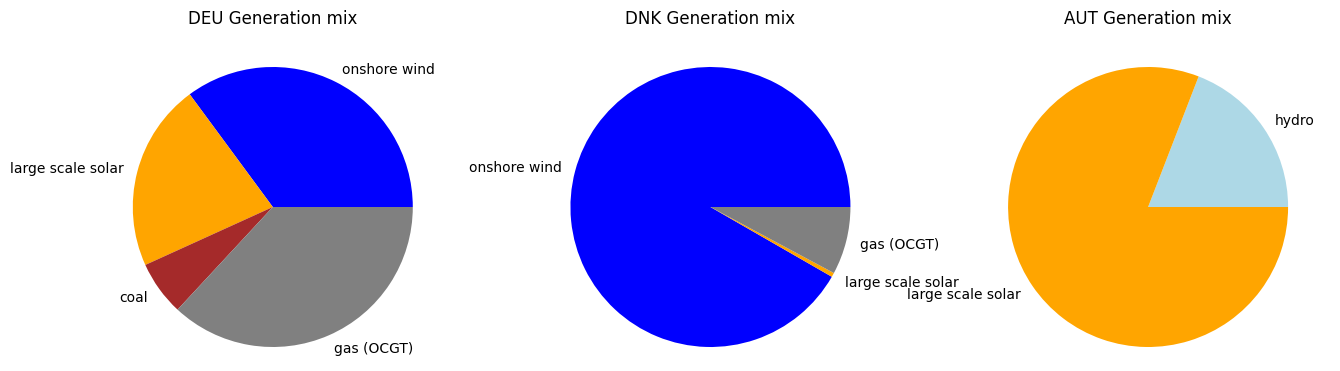

In [142]:
plt.figure(figsize=(16, 4))
#plt.title(f'Generation mix for Germany, Denmark and Austria with {CO2_limit} MtCO2 limit', fontsize=16)
colors_all = {'onshore wind': 'blue',
               'offshore wind': 'darkblue',
               'large scale solar': 'orange',
               'rooftop solar': 'yellow',
               'coal': 'brown',
               'gas (OCGT)': 'grey',
               'hydro': 'lightblue'}


for country in countries:      
   if country == "DEU":
      labels = ['onshore wind',
               'offshore wind',
               'large scale solar',
               'coal',
               'gas (OCGT)']
      sizes = [n.generators_t.p[f'onshorewind{country}'].sum(),
                     n.generators_t.p[f'offshorewind{country}'].sum(),
                  n.generators_t.p[f'PV{country}'].sum(),
                     n.generators_t.p[f'coal{country}'].sum(),
                  n.generators_t.p[f'OCGT{country}'].sum()]
      labels = [labels[i] for i in range(len(labels)) if sizes[i] > 0]
      sizes = [x for x in sizes if x > 0]
      colors = [colors_all[label] for label in labels]



      plt.subplot(1, 3, 1)
      plt.pie(sizes,
            colors=colors,
            labels=labels,
            wedgeprops={'linewidth':0})
      plt.axis('equal')

      plt.title(f'{country} Generation mix', y=1.07)
   
   if country == "DNK":
      labels = ['onshore wind',
               'offshore wind',
               'large scale solar',
               'gas (OCGT)']
      sizes = [n.generators_t.p[f'onshorewind{country}'].sum(),
                     n.generators_t.p[f'offshorewind{country}'].sum(),
                  n.generators_t.p[f'PV{country}'].sum(),
                  n.generators_t.p[f'OCGT{country}'].sum()]

      labels = [labels[i] for i in range(len(labels)) if sizes[i] > 0]
      sizes = [x for x in sizes if x > 0]
      print(labels[0])
      colors = [colors_all[label] for label in labels]

      plt.subplot(1, 3, 2)
      plt.pie(sizes,
            colors=colors,
            labels=labels,
            wedgeprops={'linewidth':0})
      plt.axis('equal')

      plt.title(f'{country} Generation mix', y=1.07)

   
   if country == "AUT":
      labels = ['hydro',
               'large scale solar',
               'gas (OCGT)']
      sizes = [n.storage_units_t.p['hydroAUT'].sum(),
                  n.generators_t.p[f'PV{country}'].sum(),
                  n.generators_t.p[f'OCGT{country}'].sum()]

      labels = [labels[i] for i in range(len(labels)) if sizes[i] > 0]
      sizes = [x for x in sizes if x > 0]
      colors = [colors_all[label] for label in labels]

      plt.subplot(1, 3, 3)
      plt.pie(sizes,
            colors=colors,
            labels=labels,
            wedgeprops={'linewidth':0})
      plt.axis('equal')

      plt.title(f'{country} Generation mix', y=1.07)

      


<AxesSubplot: xlabel='snapshot'>

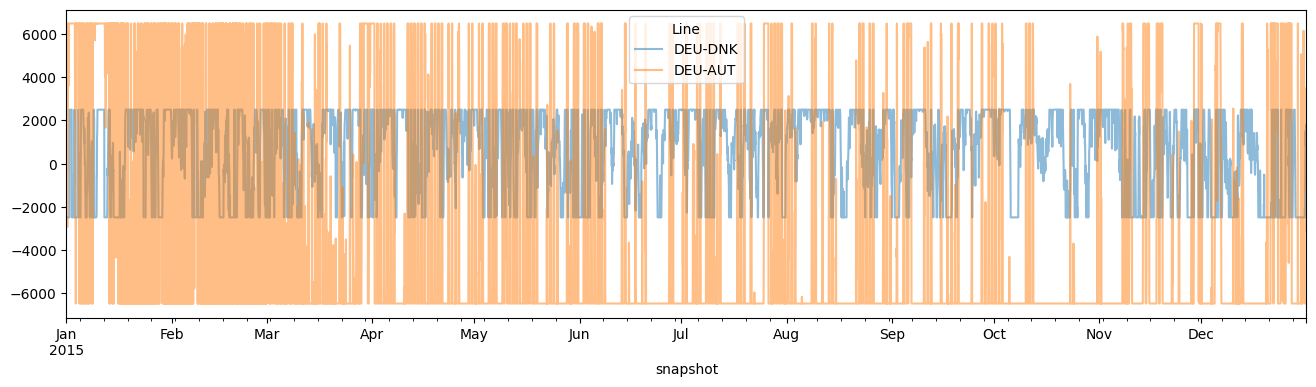

In [143]:
n.lines_t.p0.plot(figsize=(16, 4), alpha=0.5)

# Section G: Connecting to Heating sector

In [144]:
# Retrieve the heating demand data
heating_demand = pd.read_csv('data/heat_demand.csv', sep=';', index_col=0) # in MWh
heating_demand.index = pd.to_datetime(heating_demand.index) #change index to datatime

# Retrieve some capital cost data
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]
costs.at["central air-sourced heat pump", "capital_cost"]

111082358.72659878

In [145]:
for country in countries:
      # add heat bus for each country
      n.add("Bus", f"{country}_heat", carrier="heat")

      # add heat load to the bus for each country
      n.add("Load",
            f"heat_load_{country}",
            bus=f"{country}_heat",
            p_set=heating_demand[country].values)

      # Add heat pump, assuming fixed COP. Would be nice to have a variable COP, but require temperature data for each country
      fixed_cop = 2.8 # Reasonable average for the chosen countries

      n.add("Link",
            f"heat_pump_{country}",
            bus0=country,              # electricity input
            bus1=f"{country}_heat",    # heat output
            efficiency=fixed_cop,
            p_nom_extendable=True,
            carrier="heat pump",
            capital_cost=costs.at["central air-sourced heat pump", "capital_cost"],
            bidirectional=False)

      # Add CHP unit. Assume there are already withing the system
      n.add("Link",
            f"CHP_{country}",
            bus0="gas",                # gas input
            bus1=country,              # electricity output
            bus2=f"{country}_heat",    # heat output
            efficiency=0.4,            # electric efficiency
            efficiency2=0.4,           # heat efficiency
            p_nom_extendable=True,
            carrier="CHP",
            marginal_cost=80) # in €/MWh_el

Index(['CHP_DEU'], dtype='object')
Index(['CHP_DNK'], dtype='object')
Index(['CHP_AUT'], dtype='object')


In [146]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [ ]:
n.add("Carrier", "H2", co2_emissions=0)
for country in countries:
    n.add("Bus", f"{country}_H2", carrier="H2")
    n.add("Link",
          f"electrolyzer_{country}",
          bus0=country,               # electricity input
          bus1=f"{country}_H2",        # hydrogen output
          efficiency=0.8,
          p_nom_extendable=True,
          carrier="H2 electrolysis",
          capital_cost=annuity(25, 0.07)*600000*(1+0.05),
          bidirectional=False) 
    
    n.add("Store",
          f"H2_tank_{country}",
          bus=f"{country}_H2",
          e_nom_extendable=True,
          e_cyclic=True,
          capital_cost=annuity(25, 0.07)*57000*(1+0.011))
    

    n.add("Link",
          f"H2_heater_{country}",
          bus0=f"{country}_H2",
          bus1=f"{country}_heat",
          efficiency=0.9,
          p_nom_extendable=True,
          carrier="H2 heater",
          marginal_cost=30,  # adjust if needed
          capital_cost=annuity(25, 0.07)*40000,
          bidirectional=False)
    
    n.add("Link",
          f"H2 Fuel Cell_{country}",
          bus0 = f"{country}_H2",
          bus1 = f"{country}",
          p_nom_extendable = True,
          efficiency = 0.58,
          capital_cost = annuity(10, 0.07)*1300000*(1+0.05))


In [148]:
# Add a gas bus
n.add("Bus", "gas", carrier="gas")


# Add a gas store
n.add("Store",
      "gas_store",
      bus="gas",
      e_nom=1e9,  # Very large nominal energy [MWh], to simulate unlimited gas
      e_initial=1e9,
      e_cyclic=True,
      marginal_cost=0)  # Assume gas availability (fuel cost is inside marginal_cost of generators)

# Add a generator that allows gas to enter the system
n.add("Generator",
      "gas_supply",
      bus="gas",
      carrier="gas",
      p_nom=1e6,  # large enough to never limit
      marginal_cost=0)  # or set = 21.6 €/MWh_th if not already in OCGT/CHP costs


Index(['gas_supply'], dtype='object')

In [149]:
n.optimize(solver_name='gurobi')


Index(['DEU', 'DNK', 'AUT', 'DEU_heat', 'DNK_heat', 'AUT_heat'], dtype='object', name='Bus')
Index(['heat_pump_DEU', 'CHP_DEU', 'heat_pump_DNK', 'CHP_DNK', 'heat_pump_AUT',
       'CHP_AUT', 'electrolyzer_DEU', 'H2_heater_DEU', 'electrolyzer_DNK',
       'H2_heater_DNK', 'electrolyzer_AUT', 'H2_heater_AUT'],
      dtype='object', name='Link')
Index(['0'], dtype='object', name='SubNetwork')
Index(['DEU-DNK', 'DEU-AUT'], dtype='object', name='Line')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 13/13 [00:00<00:00, 13.75it/s]
INFO:linopy.io: Writing time: 6.45s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-09-04


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-09-04


Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-_03uv4wm.lp


INFO:gurobipy:Read LP format model from file C:\Users\alexk\AppData\Local\Temp\linopy-problem-_03uv4wm.lp


Reading time = 2.12 seconds


INFO:gurobipy:Reading time = 2.12 seconds


obj: 911072 rows, 420511 columns, 1879256 nonzeros


INFO:gurobipy:obj: 911072 rows, 420511 columns, 1879256 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 911072 rows, 420511 columns and 1879256 nonzeros


INFO:gurobipy:Optimize a model with 911072 rows, 420511 columns and 1879256 nonzeros


Model fingerprint: 0x75218660


INFO:gurobipy:Model fingerprint: 0x75218660


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+03]


INFO:gurobipy:  Matrix range     [1e-03, 2e+03]


  Objective range  [1e+01, 1e+08]


INFO:gurobipy:  Objective range  [1e+01, 1e+08]


  Bounds range     [1e+03, 6e+03]


INFO:gurobipy:  Bounds range     [1e+03, 6e+03]


  RHS range        [1e+03, 1e+09]


INFO:gurobipy:  RHS range        [1e+03, 1e+09]


Presolve removed 486005 rows and 47977 columns


INFO:gurobipy:Presolve removed 486005 rows and 47977 columns


Presolve time: 1.17s


INFO:gurobipy:Presolve time: 1.17s


Presolved: 425067 rows, 372534 columns, 1318997 nonzeros


INFO:gurobipy:Presolved: 425067 rows, 372534 columns, 1318997 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.57s


INFO:gurobipy:Ordering time: 0.57s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 28


INFO:gurobipy: Dense cols : 28


 AA' NZ     : 1.148e+06


INFO:gurobipy: AA' NZ     : 1.148e+06


 Factor NZ  : 6.605e+06 (roughly 400 MB of memory)


INFO:gurobipy: Factor NZ  : 6.605e+06 (roughly 400 MB of memory)


 Factor Ops : 1.700e+08 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.700e+08 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.25279509e+15 -7.10016354e+16  8.78e+10 0.00e+00  1.83e+11     3s


INFO:gurobipy:   0   1.25279509e+15 -7.10016354e+16  8.78e+10 0.00e+00  1.83e+11     3s


   1   7.76684922e+14 -1.84305891e+16  2.69e+10 3.58e+03  5.05e+10     3s


INFO:gurobipy:   1   7.76684922e+14 -1.84305891e+16  2.69e+10 3.58e+03  5.05e+10     3s


   2   2.23736014e+14 -5.56147459e+15  4.52e+09 1.07e+03  1.41e+10     4s


INFO:gurobipy:   2   2.23736014e+14 -5.56147459e+15  4.52e+09 1.07e+03  1.41e+10     4s


   3   6.20494584e+13 -6.12938604e+14  3.81e+08 1.07e+02  1.51e+09     5s


INFO:gurobipy:   3   6.20494584e+13 -6.12938604e+14  3.81e+08 1.07e+02  1.51e+09     5s


   4   2.41669788e+13 -8.14538089e+13  4.31e+07 1.19e+01  1.98e+08     5s


INFO:gurobipy:   4   2.41669788e+13 -8.14538089e+13  4.31e+07 1.19e+01  1.98e+08     5s


   5   1.37347618e+13 -1.74389106e+13  1.96e+07 2.37e+00  5.07e+07     6s


INFO:gurobipy:   5   1.37347618e+13 -1.74389106e+13  1.96e+07 2.37e+00  5.07e+07     6s


   6   6.26537733e+12 -6.41922134e+12  7.51e+06 8.31e-01  1.89e+07     6s


INFO:gurobipy:   6   6.26537733e+12 -6.41922134e+12  7.51e+06 8.31e-01  1.89e+07     6s


   7   3.15285586e+12 -1.01428314e+12  3.21e+06 1.23e-01  5.62e+06     7s


INFO:gurobipy:   7   3.15285586e+12 -1.01428314e+12  3.21e+06 1.23e-01  5.62e+06     7s


   8   2.13176407e+12 -6.65902573e+11  2.06e+06 7.78e-02  3.71e+06     7s


INFO:gurobipy:   8   2.13176407e+12 -6.65902573e+11  2.06e+06 7.78e-02  3.71e+06     7s


   9   9.58073049e+11 -2.37486615e+11  7.72e+05 2.86e-02  1.55e+06     8s


INFO:gurobipy:   9   9.58073049e+11 -2.37486615e+11  7.72e+05 2.86e-02  1.55e+06     8s


  10   5.73814684e+11 -9.72291527e+10  3.70e+05 1.61e-02  8.64e+05     8s


INFO:gurobipy:  10   5.73814684e+11 -9.72291527e+10  3.70e+05 1.61e-02  8.64e+05     8s


  11   4.03795299e+11 -6.12300990e+10  2.03e+05 1.32e-02  5.96e+05     9s


INFO:gurobipy:  11   4.03795299e+11 -6.12300990e+10  2.03e+05 1.32e-02  5.96e+05     9s


  12   3.75022895e+11  2.04409526e+10  1.77e+05 7.71e-03  4.53e+05     9s


INFO:gurobipy:  12   3.75022895e+11  2.04409526e+10  1.77e+05 7.71e-03  4.53e+05     9s


  13   2.96185572e+11  5.77843791e+10  1.15e+05 4.77e-03  3.04e+05    10s


INFO:gurobipy:  13   2.96185572e+11  5.77843791e+10  1.15e+05 4.77e-03  3.04e+05    10s


  14   2.66370072e+11  8.13273700e+10  9.15e+04 3.47e-03  2.36e+05    10s


INFO:gurobipy:  14   2.66370072e+11  8.13273700e+10  9.15e+04 3.47e-03  2.36e+05    10s


  15   2.38012926e+11  1.04095675e+11  7.00e+04 2.19e-03  1.70e+05    11s


INFO:gurobipy:  15   2.38012926e+11  1.04095675e+11  7.00e+04 2.19e-03  1.70e+05    11s


  16   2.12062747e+11  1.12992167e+11  5.04e+04 1.38e-03  1.26e+05    11s


INFO:gurobipy:  16   2.12062747e+11  1.12992167e+11  5.04e+04 1.38e-03  1.26e+05    11s


  17   1.94719738e+11  1.20582073e+11  3.68e+04 9.74e-04  9.41e+04    12s


INFO:gurobipy:  17   1.94719738e+11  1.20582073e+11  3.68e+04 9.74e-04  9.41e+04    12s


  18   1.83594461e+11  1.25536569e+11  2.87e+04 7.42e-04  7.37e+04    13s


INFO:gurobipy:  18   1.83594461e+11  1.25536569e+11  2.87e+04 7.42e-04  7.37e+04    13s


  19   1.79869063e+11  1.28794506e+11  2.59e+04 6.25e-04  6.48e+04    13s


INFO:gurobipy:  19   1.79869063e+11  1.28794506e+11  2.59e+04 6.25e-04  6.48e+04    13s


  20   1.75185266e+11  1.35424673e+11  2.21e+04 3.99e-04  5.05e+04    14s


INFO:gurobipy:  20   1.75185266e+11  1.35424673e+11  2.21e+04 3.99e-04  5.05e+04    14s


  21   1.68790634e+11  1.38821000e+11  1.68e+04 2.67e-04  3.81e+04    15s


INFO:gurobipy:  21   1.68790634e+11  1.38821000e+11  1.68e+04 2.67e-04  3.81e+04    15s


  22   1.65271356e+11  1.39932963e+11  1.40e+04 2.36e-04  3.22e+04    15s


INFO:gurobipy:  22   1.65271356e+11  1.39932963e+11  1.40e+04 2.36e-04  3.22e+04    15s


  23   1.64125985e+11  1.40458825e+11  1.30e+04 2.21e-04  3.00e+04    16s


INFO:gurobipy:  23   1.64125985e+11  1.40458825e+11  1.30e+04 2.21e-04  3.00e+04    16s


  24   1.61427007e+11  1.42463556e+11  1.07e+04 1.67e-04  2.41e+04    16s


INFO:gurobipy:  24   1.61427007e+11  1.42463556e+11  1.07e+04 1.67e-04  2.41e+04    16s


  25   1.59483586e+11  1.43597426e+11  9.05e+03 1.37e-04  2.02e+04    17s


INFO:gurobipy:  25   1.59483586e+11  1.43597426e+11  9.05e+03 1.37e-04  2.02e+04    17s


  26   1.57945832e+11  1.45023588e+11  7.65e+03 1.01e-04  1.64e+04    18s


INFO:gurobipy:  26   1.57945832e+11  1.45023588e+11  7.65e+03 1.01e-04  1.64e+04    18s


  27   1.56251302e+11  1.45284578e+11  6.22e+03 9.32e-05  1.39e+04    18s


INFO:gurobipy:  27   1.56251302e+11  1.45284578e+11  6.22e+03 9.32e-05  1.39e+04    18s


  28   1.55571097e+11  1.45712775e+11  5.60e+03 8.11e-05  1.25e+04    19s


INFO:gurobipy:  28   1.55571097e+11  1.45712775e+11  5.60e+03 8.11e-05  1.25e+04    19s


  29   1.54737350e+11  1.46648963e+11  4.80e+03 6.06e-05  1.03e+04    20s


INFO:gurobipy:  29   1.54737350e+11  1.46648963e+11  4.80e+03 6.06e-05  1.03e+04    20s


  30   1.54213618e+11  1.46869830e+11  4.31e+03 5.60e-05  9.32e+03    20s


INFO:gurobipy:  30   1.54213618e+11  1.46869830e+11  4.31e+03 5.60e-05  9.32e+03    20s


  31   1.53426420e+11  1.47579965e+11  3.57e+03 4.02e-05  7.42e+03    21s


INFO:gurobipy:  31   1.53426420e+11  1.47579965e+11  3.57e+03 4.02e-05  7.42e+03    21s


  32   1.53297333e+11  1.47646542e+11  3.46e+03 3.84e-05  7.18e+03    22s


INFO:gurobipy:  32   1.53297333e+11  1.47646542e+11  3.46e+03 3.84e-05  7.18e+03    22s


  33   1.52892497e+11  1.47915843e+11  3.09e+03 3.13e-05  6.32e+03    22s


INFO:gurobipy:  33   1.52892497e+11  1.47915843e+11  3.09e+03 3.13e-05  6.32e+03    22s


  34   1.52331210e+11  1.48185410e+11  2.53e+03 2.47e-05  5.26e+03    23s


INFO:gurobipy:  34   1.52331210e+11  1.48185410e+11  2.53e+03 2.47e-05  5.26e+03    23s


  35   1.52036923e+11  1.48408652e+11  2.26e+03 2.10e-05  4.61e+03    24s


INFO:gurobipy:  35   1.52036923e+11  1.48408652e+11  2.26e+03 2.10e-05  4.61e+03    24s


  36   1.51947461e+11  1.48501722e+11  2.17e+03 1.96e-05  4.38e+03    24s


INFO:gurobipy:  36   1.51947461e+11  1.48501722e+11  2.17e+03 1.96e-05  4.38e+03    24s


  37   1.51776796e+11  1.48672977e+11  2.00e+03 1.70e-05  3.94e+03    25s


INFO:gurobipy:  37   1.51776796e+11  1.48672977e+11  2.00e+03 1.70e-05  3.94e+03    25s


  38   1.51653522e+11  1.48845960e+11  1.86e+03 1.32e-05  3.57e+03    26s


INFO:gurobipy:  38   1.51653522e+11  1.48845960e+11  1.86e+03 1.32e-05  3.57e+03    26s


  39   1.51431017e+11  1.49085188e+11  1.64e+03 1.01e-05  2.98e+03    26s


INFO:gurobipy:  39   1.51431017e+11  1.49085188e+11  1.64e+03 1.01e-05  2.98e+03    26s


  40   1.51180667e+11  1.49228556e+11  1.37e+03 8.31e-06  2.48e+03    27s


INFO:gurobipy:  40   1.51180667e+11  1.49228556e+11  1.37e+03 8.31e-06  2.48e+03    27s


  41   1.50979361e+11  1.49383249e+11  1.14e+03 6.44e-06  2.03e+03    28s


INFO:gurobipy:  41   1.50979361e+11  1.49383249e+11  1.14e+03 6.44e-06  2.03e+03    28s


  42   1.50864829e+11  1.49408692e+11  1.01e+03 6.15e-06  1.85e+03    28s


INFO:gurobipy:  42   1.50864829e+11  1.49408692e+11  1.01e+03 6.15e-06  1.85e+03    28s


  43   1.50733069e+11  1.49516150e+11  8.68e+02 4.93e-06  1.55e+03    29s


INFO:gurobipy:  43   1.50733069e+11  1.49516150e+11  8.68e+02 4.93e-06  1.55e+03    29s


  44   1.50679714e+11  1.49590997e+11  8.09e+02 4.13e-06  1.38e+03    29s


INFO:gurobipy:  44   1.50679714e+11  1.49590997e+11  8.09e+02 4.13e-06  1.38e+03    29s


  45   1.50580900e+11  1.49616066e+11  6.90e+02 3.65e-06  1.23e+03    30s


INFO:gurobipy:  45   1.50580900e+11  1.49616066e+11  6.90e+02 3.65e-06  1.23e+03    30s


  46   1.50495295e+11  1.49669245e+11  5.96e+02 3.12e-06  1.05e+03    31s


INFO:gurobipy:  46   1.50495295e+11  1.49669245e+11  5.96e+02 3.12e-06  1.05e+03    31s


  47   1.50453039e+11  1.49734190e+11  5.48e+02 2.49e-06  9.14e+02    31s


INFO:gurobipy:  47   1.50453039e+11  1.49734190e+11  5.48e+02 2.49e-06  9.14e+02    31s


  48   1.50406722e+11  1.49751146e+11  4.94e+02 2.19e-06  8.34e+02    32s


INFO:gurobipy:  48   1.50406722e+11  1.49751146e+11  4.94e+02 2.19e-06  8.34e+02    32s


  49   1.50328610e+11  1.49774770e+11  3.95e+02 1.78e-06  7.04e+02    33s


INFO:gurobipy:  49   1.50328610e+11  1.49774770e+11  3.95e+02 1.78e-06  7.04e+02    33s


  50   1.50264494e+11  1.49838411e+11  3.06e+02 1.33e-06  5.42e+02    33s


INFO:gurobipy:  50   1.50264494e+11  1.49838411e+11  3.06e+02 1.33e-06  5.42e+02    33s


  51   1.50237152e+11  1.49870009e+11  2.72e+02 1.11e-06  4.67e+02    34s


INFO:gurobipy:  51   1.50237152e+11  1.49870009e+11  2.72e+02 1.11e-06  4.67e+02    34s


  52   1.50177301e+11  1.49894998e+11  1.93e+02 7.71e-07  3.59e+02    34s


INFO:gurobipy:  52   1.50177301e+11  1.49894998e+11  1.93e+02 7.71e-07  3.59e+02    34s


  53   1.50163858e+11  1.49924305e+11  1.75e+02 6.10e-07  3.05e+02    35s


INFO:gurobipy:  53   1.50163858e+11  1.49924305e+11  1.75e+02 6.10e-07  3.05e+02    35s


  54   1.50138562e+11  1.49933839e+11  1.41e+02 4.88e-07  2.60e+02    36s


INFO:gurobipy:  54   1.50138562e+11  1.49933839e+11  1.41e+02 4.88e-07  2.60e+02    36s


  55   1.50120763e+11  1.49947449e+11  1.18e+02 4.36e-07  2.20e+02    36s


INFO:gurobipy:  55   1.50120763e+11  1.49947449e+11  1.18e+02 4.36e-07  2.20e+02    36s


  56   1.50105948e+11  1.49956028e+11  9.98e+01 3.97e-07  1.90e+02    37s


INFO:gurobipy:  56   1.50105948e+11  1.49956028e+11  9.98e+01 3.97e-07  1.90e+02    37s


  57   1.50102483e+11  1.49960769e+11  9.54e+01 3.80e-07  1.80e+02    38s


INFO:gurobipy:  57   1.50102483e+11  1.49960769e+11  9.54e+01 3.80e-07  1.80e+02    38s


  58   1.50090634e+11  1.49969669e+11  8.07e+01 3.48e-07  1.54e+02    38s


INFO:gurobipy:  58   1.50090634e+11  1.49969669e+11  8.07e+01 3.48e-07  1.54e+02    38s


  59   1.50082233e+11  1.49972740e+11  7.02e+01 3.39e-07  1.39e+02    39s


INFO:gurobipy:  59   1.50082233e+11  1.49972740e+11  7.02e+01 3.39e-07  1.39e+02    39s


  60   1.50081173e+11  1.49973500e+11  6.88e+01 3.35e-07  1.37e+02    39s


INFO:gurobipy:  60   1.50081173e+11  1.49973500e+11  6.88e+01 3.35e-07  1.37e+02    39s


  61   1.50076273e+11  1.49984902e+11  6.26e+01 3.84e-07  1.16e+02    40s


INFO:gurobipy:  61   1.50076273e+11  1.49984902e+11  6.26e+01 3.84e-07  1.16e+02    40s


  62   1.50074274e+11  1.49986419e+11  6.00e+01 3.48e-07  1.12e+02    41s


INFO:gurobipy:  62   1.50074274e+11  1.49986419e+11  6.00e+01 3.48e-07  1.12e+02    41s


  63   1.50070513e+11  1.49991346e+11  5.53e+01 2.57e-07  1.01e+02    41s


INFO:gurobipy:  63   1.50070513e+11  1.49991346e+11  5.53e+01 2.57e-07  1.01e+02    41s


  64   1.50067894e+11  1.49992536e+11  5.21e+01 2.37e-07  9.58e+01    42s


INFO:gurobipy:  64   1.50067894e+11  1.49992536e+11  5.21e+01 2.37e-07  9.58e+01    42s


  65   1.50064259e+11  1.49994793e+11  4.78e+01 2.26e-07  8.83e+01    42s


INFO:gurobipy:  65   1.50064259e+11  1.49994793e+11  4.78e+01 2.26e-07  8.83e+01    42s


  66   1.50061039e+11  1.49996911e+11  4.37e+01 3.28e-07  8.15e+01    43s


INFO:gurobipy:  66   1.50061039e+11  1.49996911e+11  4.37e+01 3.28e-07  8.15e+01    43s


  67   1.50056030e+11  1.50001971e+11  3.76e+01 1.82e-07  6.87e+01    44s


INFO:gurobipy:  67   1.50056030e+11  1.50001971e+11  3.76e+01 1.82e-07  6.87e+01    44s


  68   1.50054446e+11  1.50004387e+11  3.57e+01 1.67e-07  6.36e+01    44s


INFO:gurobipy:  68   1.50054446e+11  1.50004387e+11  3.57e+01 1.67e-07  6.36e+01    44s


  69   1.50052073e+11  1.50005197e+11  3.27e+01 1.62e-07  5.96e+01    45s


INFO:gurobipy:  69   1.50052073e+11  1.50005197e+11  3.27e+01 1.62e-07  5.96e+01    45s


  70   1.50049839e+11  1.50006278e+11  2.98e+01 2.22e-07  5.54e+01    45s


INFO:gurobipy:  70   1.50049839e+11  1.50006278e+11  2.98e+01 2.22e-07  5.54e+01    45s


  71   1.50047500e+11  1.50007508e+11  2.69e+01 1.47e-07  5.08e+01    46s


INFO:gurobipy:  71   1.50047500e+11  1.50007508e+11  2.69e+01 1.47e-07  5.08e+01    46s


  72   1.50045245e+11  1.50009168e+11  2.41e+01 1.36e-07  4.58e+01    47s


INFO:gurobipy:  72   1.50045245e+11  1.50009168e+11  2.41e+01 1.36e-07  4.58e+01    47s


  73   1.50043976e+11  1.50011760e+11  2.26e+01 1.17e-07  4.09e+01    47s


INFO:gurobipy:  73   1.50043976e+11  1.50011760e+11  2.26e+01 1.17e-07  4.09e+01    47s


  74   1.50043161e+11  1.50012087e+11  2.16e+01 1.15e-07  3.95e+01    48s


INFO:gurobipy:  74   1.50043161e+11  1.50012087e+11  2.16e+01 1.15e-07  3.95e+01    48s


  75   1.50042458e+11  1.50012891e+11  2.07e+01 1.12e-07  3.76e+01    49s


INFO:gurobipy:  75   1.50042458e+11  1.50012891e+11  2.07e+01 1.12e-07  3.76e+01    49s


  76   1.50040977e+11  1.50013855e+11  1.87e+01 1.05e-07  3.45e+01    49s


INFO:gurobipy:  76   1.50040977e+11  1.50013855e+11  1.87e+01 1.05e-07  3.45e+01    49s


  77   1.50039752e+11  1.50014935e+11  1.71e+01 9.66e-08  3.15e+01    50s


INFO:gurobipy:  77   1.50039752e+11  1.50014935e+11  1.71e+01 9.66e-08  3.15e+01    50s


  78   1.50038886e+11  1.50015873e+11  1.61e+01 8.87e-08  2.92e+01    51s


INFO:gurobipy:  78   1.50038886e+11  1.50015873e+11  1.61e+01 8.87e-08  2.92e+01    51s


  79   1.50037937e+11  1.50016551e+11  1.49e+01 8.30e-08  2.72e+01    51s


INFO:gurobipy:  79   1.50037937e+11  1.50016551e+11  1.49e+01 8.30e-08  2.72e+01    51s


  80   1.50037555e+11  1.50017076e+11  1.44e+01 7.90e-08  2.60e+01    52s


INFO:gurobipy:  80   1.50037555e+11  1.50017076e+11  1.44e+01 7.90e-08  2.60e+01    52s


  81   1.50036846e+11  1.50018043e+11  1.35e+01 7.15e-08  2.39e+01    52s


INFO:gurobipy:  81   1.50036846e+11  1.50018043e+11  1.35e+01 7.15e-08  2.39e+01    52s


  82   1.50036128e+11  1.50018426e+11  1.26e+01 7.03e-08  2.25e+01    53s


INFO:gurobipy:  82   1.50036128e+11  1.50018426e+11  1.26e+01 7.03e-08  2.25e+01    53s


  83   1.50035577e+11  1.50018555e+11  1.19e+01 6.92e-08  2.16e+01    54s


INFO:gurobipy:  83   1.50035577e+11  1.50018555e+11  1.19e+01 6.92e-08  2.16e+01    54s


  84   1.50035020e+11  1.50018761e+11  1.12e+01 6.85e-08  2.07e+01    54s


INFO:gurobipy:  84   1.50035020e+11  1.50018761e+11  1.12e+01 6.85e-08  2.07e+01    54s


  85   1.50034233e+11  1.50019187e+11  1.02e+01 6.47e-08  1.91e+01    55s


INFO:gurobipy:  85   1.50034233e+11  1.50019187e+11  1.02e+01 6.47e-08  1.91e+01    55s


  86   1.50033363e+11  1.50019568e+11  9.11e+00 6.13e-08  1.75e+01    55s


INFO:gurobipy:  86   1.50033363e+11  1.50019568e+11  9.11e+00 6.13e-08  1.75e+01    55s


  87   1.50032791e+11  1.50019993e+11  8.39e+00 5.75e-08  1.63e+01    56s


INFO:gurobipy:  87   1.50032791e+11  1.50019993e+11  8.39e+00 5.75e-08  1.63e+01    56s


  88   1.50032459e+11  1.50020311e+11  7.95e+00 5.50e-08  1.54e+01    57s


INFO:gurobipy:  88   1.50032459e+11  1.50020311e+11  7.95e+00 5.50e-08  1.54e+01    57s


  89   1.50032079e+11  1.50020803e+11  7.48e+00 5.12e-08  1.43e+01    57s


INFO:gurobipy:  89   1.50032079e+11  1.50020803e+11  7.48e+00 5.12e-08  1.43e+01    57s


  90   1.50031818e+11  1.50020983e+11  7.16e+00 5.07e-08  1.38e+01    58s


INFO:gurobipy:  90   1.50031818e+11  1.50020983e+11  7.16e+00 5.07e-08  1.38e+01    58s


  91   1.50031711e+11  1.50021375e+11  7.02e+00 4.75e-08  1.31e+01    58s


INFO:gurobipy:  91   1.50031711e+11  1.50021375e+11  7.02e+00 4.75e-08  1.31e+01    58s


  92   1.50031263e+11  1.50021735e+11  6.47e+00 4.43e-08  1.21e+01    59s


INFO:gurobipy:  92   1.50031263e+11  1.50021735e+11  6.47e+00 4.43e-08  1.21e+01    59s


  93   1.50031042e+11  1.50021947e+11  6.19e+00 4.22e-08  1.16e+01    60s


INFO:gurobipy:  93   1.50031042e+11  1.50021947e+11  6.19e+00 4.22e-08  1.16e+01    60s


  94   1.50030799e+11  1.50022099e+11  5.89e+00 4.09e-08  1.11e+01    60s


INFO:gurobipy:  94   1.50030799e+11  1.50022099e+11  5.89e+00 4.09e-08  1.11e+01    60s


  95   1.50030611e+11  1.50022288e+11  5.66e+00 3.91e-08  1.06e+01    61s


INFO:gurobipy:  95   1.50030611e+11  1.50022288e+11  5.66e+00 3.91e-08  1.06e+01    61s


  96   1.50030471e+11  1.50022657e+11  5.48e+00 3.55e-08  9.93e+00    61s


INFO:gurobipy:  96   1.50030471e+11  1.50022657e+11  5.48e+00 3.55e-08  9.93e+00    61s


  97   1.50029675e+11  1.50023069e+11  4.50e+00 3.47e-08  8.39e+00    62s


INFO:gurobipy:  97   1.50029675e+11  1.50023069e+11  4.50e+00 3.47e-08  8.39e+00    62s


  98   1.50029058e+11  1.50023365e+11  3.76e+00 3.15e-08  7.23e+00    63s


INFO:gurobipy:  98   1.50029058e+11  1.50023365e+11  3.76e+00 3.15e-08  7.23e+00    63s


  99   1.50028924e+11  1.50023599e+11  3.60e+00 2.89e-08  6.76e+00    63s


INFO:gurobipy:  99   1.50028924e+11  1.50023599e+11  3.60e+00 2.89e-08  6.76e+00    63s


 100   1.50028307e+11  1.50024104e+11  2.83e+00 3.17e-08  5.34e+00    64s


INFO:gurobipy: 100   1.50028307e+11  1.50024104e+11  2.83e+00 3.17e-08  5.34e+00    64s


 101   1.50027992e+11  1.50024274e+11  2.43e+00 2.89e-08  4.72e+00    64s


INFO:gurobipy: 101   1.50027992e+11  1.50024274e+11  2.43e+00 2.89e-08  4.72e+00    64s


 102   1.50027939e+11  1.50024338e+11  2.36e+00 2.86e-08  4.57e+00    65s


INFO:gurobipy: 102   1.50027939e+11  1.50024338e+11  2.36e+00 2.86e-08  4.57e+00    65s


 103   1.50027756e+11  1.50024441e+11  2.13e+00 2.80e-08  4.21e+00    65s


INFO:gurobipy: 103   1.50027756e+11  1.50024441e+11  2.13e+00 2.80e-08  4.21e+00    65s


 104   1.50027634e+11  1.50024756e+11  2.00e+00 2.23e-08  3.66e+00    66s


INFO:gurobipy: 104   1.50027634e+11  1.50024756e+11  2.00e+00 2.23e-08  3.66e+00    66s


 105   1.50027442e+11  1.50025209e+11  1.78e+00 1.40e-08  2.84e+00    67s


INFO:gurobipy: 105   1.50027442e+11  1.50025209e+11  1.78e+00 1.40e-08  2.84e+00    67s


 106   1.50027390e+11  1.50025336e+11  1.72e+00 1.16e-08  2.61e+00    67s


INFO:gurobipy: 106   1.50027390e+11  1.50025336e+11  1.72e+00 1.16e-08  2.61e+00    67s


 107   1.50027346e+11  1.50025379e+11  1.66e+00 1.45e-08  2.50e+00    68s


INFO:gurobipy: 107   1.50027346e+11  1.50025379e+11  1.66e+00 1.45e-08  2.50e+00    68s


 108   1.50027341e+11  1.50025388e+11  1.65e+00 1.39e-08  2.49e+00    68s


INFO:gurobipy: 108   1.50027341e+11  1.50025388e+11  1.65e+00 1.39e-08  2.49e+00    68s


 109   1.50027280e+11  1.50025465e+11  1.59e+00 1.25e-08  2.31e+00    69s


INFO:gurobipy: 109   1.50027280e+11  1.50025465e+11  1.59e+00 1.25e-08  2.31e+00    69s


 110   1.50026685e+11  1.50025694e+11  8.72e-01 1.14e-08  1.26e+00    70s


INFO:gurobipy: 110   1.50026685e+11  1.50025694e+11  8.72e-01 1.14e-08  1.26e+00    70s


 111   1.50026382e+11  1.50025806e+11  5.15e-01 6.27e-09  7.35e-01    70s


INFO:gurobipy: 111   1.50026382e+11  1.50025806e+11  5.15e-01 6.27e-09  7.35e-01    70s


 112   1.50026354e+11  1.50025895e+11  4.82e-01 7.75e-09  5.86e-01    71s


INFO:gurobipy: 112   1.50026354e+11  1.50025895e+11  4.82e-01 7.75e-09  5.86e-01    71s


 113   1.50026049e+11  1.50025932e+11  1.25e-01 9.34e-09  1.49e-01    71s


INFO:gurobipy: 113   1.50026049e+11  1.50025932e+11  1.25e-01 9.34e-09  1.49e-01    71s


 114   1.50026044e+11  1.50025933e+11  1.19e-01 3.10e-08  1.41e-01    72s


INFO:gurobipy: 114   1.50026044e+11  1.50025933e+11  1.19e-01 3.10e-08  1.41e-01    72s


 115   1.50026036e+11  1.50025934e+11  1.09e-01 7.31e-08  1.30e-01    72s


INFO:gurobipy: 115   1.50026036e+11  1.50025934e+11  1.09e-01 7.31e-08  1.30e-01    72s


 116   1.50026007e+11  1.50025934e+11  7.64e-02 1.07e-07  9.31e-02    72s


INFO:gurobipy: 116   1.50026007e+11  1.50025934e+11  7.64e-02 1.07e-07  9.31e-02    72s


 117   1.50025997e+11  1.50025935e+11  6.47e-02 8.23e-08  7.90e-02    73s


INFO:gurobipy: 117   1.50025997e+11  1.50025935e+11  6.47e-02 8.23e-08  7.90e-02    73s


 118   1.50025981e+11  1.50025937e+11  4.63e-02 2.26e-07  5.71e-02    73s


INFO:gurobipy: 118   1.50025981e+11  1.50025937e+11  4.63e-02 2.26e-07  5.71e-02    73s


 119   1.50025958e+11  1.50025938e+11  1.94e-02 6.85e-08  2.44e-02    73s


INFO:gurobipy: 119   1.50025958e+11  1.50025938e+11  1.94e-02 6.85e-08  2.44e-02    73s


 120   1.50025940e+11  1.50025939e+11  3.61e-04 4.24e-08  2.96e-04    74s


INFO:gurobipy: 120   1.50025940e+11  1.50025939e+11  3.61e-04 4.24e-08  2.96e-04    74s


 121   1.50025939e+11  1.50025939e+11  1.14e-06 1.62e-06  1.66e-08    74s


INFO:gurobipy: 121   1.50025939e+11  1.50025939e+11  1.14e-06 1.62e-06  1.66e-08    74s


 122   1.50025939e+11  1.50025939e+11  5.51e-06 2.31e-09  2.87e-13    75s


INFO:gurobipy: 122   1.50025939e+11  1.50025939e+11  5.51e-06 2.31e-09  2.87e-13    75s


INFO:gurobipy:


Barrier solved model in 122 iterations and 74.69 seconds (28.32 work units)


INFO:gurobipy:Barrier solved model in 122 iterations and 74.69 seconds (28.32 work units)


Optimal objective 1.50025939e+11


INFO:gurobipy:Optimal objective 1.50025939e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  149124 DPushes remaining with DInf 0.0000000e+00                75s


INFO:gurobipy:  149124 DPushes remaining with DInf 0.0000000e+00                75s


       0 DPushes remaining with DInf 0.0000000e+00                77s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                77s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   61795 PPushes remaining with PInf 0.0000000e+00                77s


INFO:gurobipy:   61795 PPushes remaining with PInf 0.0000000e+00                77s


   41927 PPushes remaining with PInf 0.0000000e+00                82s


INFO:gurobipy:   41927 PPushes remaining with PInf 0.0000000e+00                82s


   36493 PPushes remaining with PInf 0.0000000e+00                85s


INFO:gurobipy:   36493 PPushes remaining with PInf 0.0000000e+00                85s


   28368 PPushes remaining with PInf 0.0000000e+00                90s


INFO:gurobipy:   28368 PPushes remaining with PInf 0.0000000e+00                90s


   18422 PPushes remaining with PInf 0.0000000e+00                95s


INFO:gurobipy:   18422 PPushes remaining with PInf 0.0000000e+00                95s


    7621 PPushes remaining with PInf 0.0000000e+00               100s


INFO:gurobipy:    7621 PPushes remaining with PInf 0.0000000e+00               100s


       0 PPushes remaining with PInf 0.0000000e+00               104s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00               104s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.1573274e-09    104s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.1573274e-09    104s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  130009    1.5002594e+11   0.000000e+00   2.000000e-06    105s


INFO:gurobipy:  130009    1.5002594e+11   0.000000e+00   2.000000e-06    105s


Extra simplex iterations after uncrush: 1


INFO:gurobipy:Extra simplex iterations after uncrush: 1


  130010    1.5002594e+11   0.000000e+00   0.000000e+00    106s


INFO:gurobipy:  130010    1.5002594e+11   0.000000e+00   0.000000e+00    106s


INFO:gurobipy:


Solved in 130010 iterations and 105.82 seconds (48.46 work units)


INFO:gurobipy:Solved in 130010 iterations and 105.82 seconds (48.46 work units)


Optimal objective  1.500259393e+11


INFO:gurobipy:Optimal objective  1.500259393e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 420511 primals, 911072 duals
Objective: 1.50e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Line-fix-s-lower, Line-fix-s-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

In [150]:
# Installed capacities (MW)
print(n.generators.p_nom_opt)


Generator
onshorewindDEU      394687.311638
offshorewindDEU          0.000000
PVDEU               322246.322105
OCGTDEU              11899.410801
coalDEU                  0.000000
onshorewindDNK       31757.054971
offshorewindDNK          0.000000
PVDNK                 7086.307705
OCGTDNK                  0.000000
PVAUT               131805.658551
OCGTAUT                  0.000000
gas_supply         1000000.000000
Name: p_nom_opt, dtype: float64


In [151]:
print(n.links.p_nom_opt)


Link
heat_pump_DEU            0.000000
CHP_DEU             558493.061129
heat_pump_DNK            0.000000
CHP_DNK              34800.945573
heat_pump_AUT            0.000000
CHP_AUT              60237.703378
electrolyzer_DEU    176030.156639
H2_heater_DEU       173443.530337
H2 Fuel Cell             0.000000
electrolyzer_DNK     12596.468459
H2_heater_DNK        11659.263188
electrolyzer_AUT     18710.244015
H2_heater_AUT        17149.590440
Name: p_nom_opt, dtype: float64


In [152]:
print(n.stores.e_nom_opt)


Store
H2_tank_DEU    6.503278e+05
H2_tank_DNK    3.265432e+04
H2_tank_AUT    3.369354e+04
gas_store      1.000000e+09
Name: e_nom_opt, dtype: float64


In [153]:
print(n.storage_units.p_nom_opt)


StorageUnit
batteryDEU    11796.849728
batteryDNK        0.000000
hydroAUT      50386.175700
batteryAUT        0.000000
Name: p_nom_opt, dtype: float64


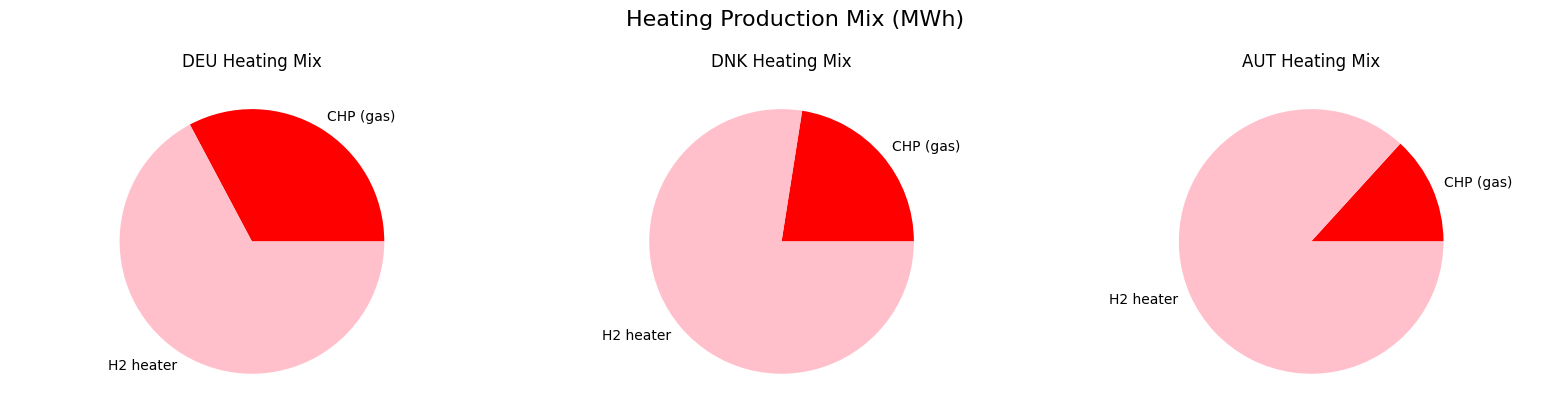

In [154]:
colors_heat = {
    'heat pump': 'green',
    'CHP (gas)': 'red',
    'H2 heater': 'pink'
}

plt.figure(figsize=(16, 4))

for i, country in enumerate(countries):
    labels = []
    sizes = []

    # Heat pump output (electricity -> heat)
    hp = f'heat_pump_{country}'
    if hp in n.links.index:
        value = -n.links_t.p1[hp].sum()  # flip sign
        if value > 0.1:
            labels.append('heat pump')
            sizes.append(value)

    # CHP output (gas -> electricity + heat)
    chp = f'CHP_{country}'
    if chp in n.links.index:
        value = -n.links_t.p2[chp].sum()  # flip sign
        if value > 0.1:
            labels.append('CHP (gas)')
            sizes.append(value)

    # H2 heater output
    h2 = f'H2_heater_{country}'
    if h2 in n.links.index:
        value = -n.links_t.p1[h2].sum()  # flip sign
        if value > 0.1:
            labels.append('H2 heater')
            sizes.append(value)

    if sizes:
        colors = [colors_heat[label] for label in labels]
        plt.subplot(1, 3, i + 1)
        plt.pie(sizes, labels=labels, colors=colors, wedgeprops={'linewidth': 0})
        plt.axis('equal')
        plt.title(f"{country} Heating Mix", y=1.07)
    else:
        plt.subplot(1, 3, i + 1)
        plt.text(0.5, 0.5, 'No heating', ha='center', va='center')
        plt.axis('off')

plt.suptitle("Heating Production Mix (MWh)", fontsize=16)
plt.tight_layout()
plt.show()


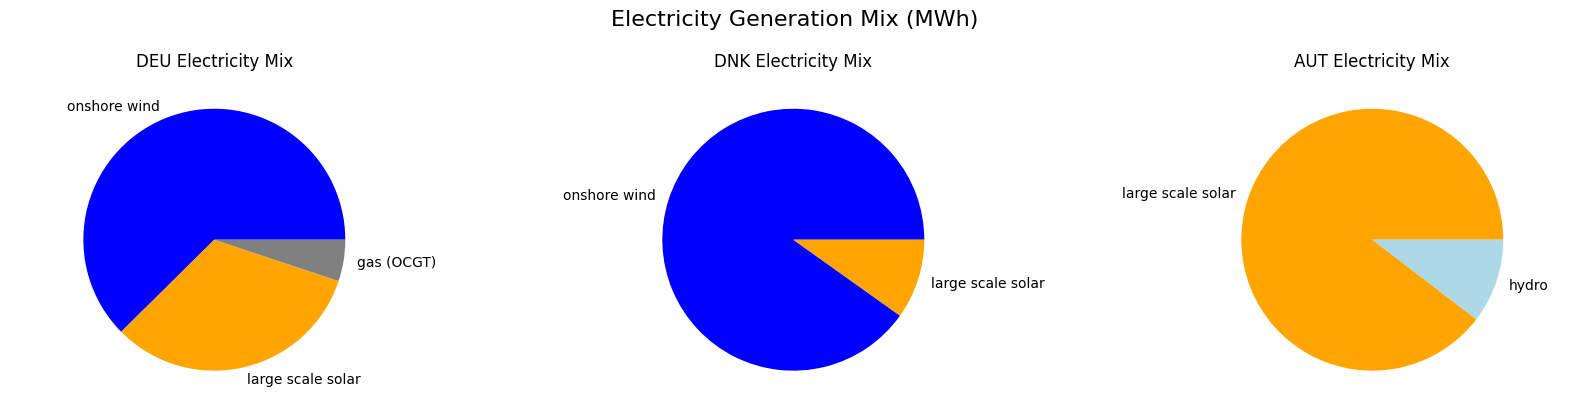

In [155]:
colors_gen = {
    'onshore wind': 'blue',
    'offshore wind': 'darkblue',
    'large scale solar': 'orange',
    'gas (OCGT)': 'grey',
    'coal': 'brown',
    'hydro': 'lightblue'
}

plt.figure(figsize=(16, 4))

for i, country in enumerate(countries):
    labels = []
    sizes = []

    # Onshore wind
    if f'onshorewind{country}' in n.generators.index:
        value = n.generators_t.p[f'onshorewind{country}'].sum()
        if value > 0.1:
            labels.append('onshore wind')
            sizes.append(value)

    # Offshore wind
    if f'offshorewind{country}' in n.generators.index:
        value = n.generators_t.p[f'offshorewind{country}'].sum()
        if value > 0.1:
            labels.append('offshore wind')
            sizes.append(value)

    # PV
    if f'PV{country}' in n.generators.index:
        value = n.generators_t.p[f'PV{country}'].sum()
        if value > 0.1:
            labels.append('large scale solar')
            sizes.append(value)

    # OCGT
    if f'OCGT{country}' in n.generators.index:
        value = n.generators_t.p[f'OCGT{country}'].sum()
        if value > 0.1:
            labels.append('gas (OCGT)')
            sizes.append(value)

    # Coal
    if f'coal{country}' in n.generators.index:
        value = n.generators_t.p[f'coal{country}'].sum()
        if value > 0.1:
            labels.append('coal')
            sizes.append(value)

    # Hydro (storage unit dispatch)
    if f"hydro{country}" in n.storage_units.index:
        value = n.storage_units_t.p[f"hydro{country}"].sum()
        if value > 0.1:
            labels.append('hydro')
            sizes.append(value)

    if sizes:
        colors = [colors_gen[label] for label in labels]
        plt.subplot(1, 3, i + 1)
        plt.pie(sizes, labels=labels, colors=colors, wedgeprops={'linewidth': 0})
        plt.axis('equal')
        plt.title(f"{country} Electricity Mix", y=1.07)
    else:
        plt.subplot(1, 3, i + 1)
        plt.text(0.5, 0.5, 'No generation', ha='center', va='center')
        plt.axis('off')

plt.suptitle("Electricity Generation Mix (MWh)", fontsize=16)
plt.tight_layout()
plt.show()


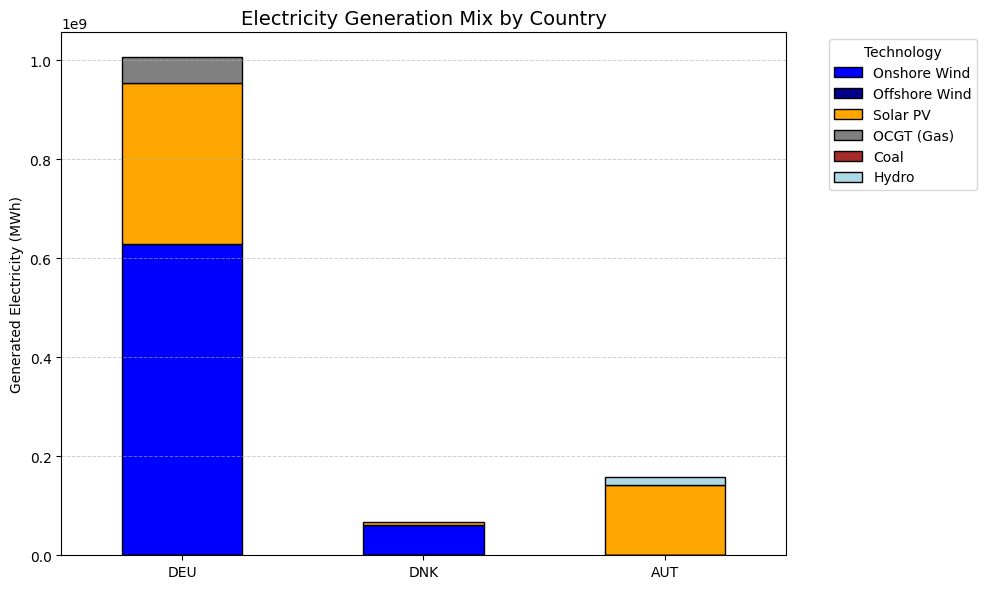

In [156]:
# Define the technologies and their labels/colors
tech_labels = {
    'onshorewind': 'Onshore Wind',
    'offshorewind': 'Offshore Wind',
    'PV': 'Solar PV',
    'OCGT': 'OCGT (Gas)',
    'coal': 'Coal',
    'hydro': 'Hydro'
}

colors = {
    'Onshore Wind': 'blue',
    'Offshore Wind': 'darkblue',
    'Solar PV': 'orange',
    'OCGT (Gas)': 'grey',
    'Coal': 'brown',
    'Hydro': 'lightblue'
}

# Initialize dataframe to collect generation by country and tech
df_gen = pd.DataFrame(0.0, index=tech_labels.values(), columns=countries)

for country in countries:
    for tech_key, tech_label in tech_labels.items():
        if tech_key == "hydro":
            unit_name = f"hydro{country}"
            if unit_name in n.storage_units.index:
                value = n.storage_units_t.p[unit_name].sum()
                df_gen.at[tech_label, country] = value
        else:
            gen_name = f"{tech_key}{country}"
            if gen_name in n.generators.index:
                value = n.generators_t.p[gen_name].sum()
                df_gen.at[tech_label, country] = value

# Plot
ax = df_gen.T.plot(kind='bar', stacked=True, color=[colors[t] for t in df_gen.index],
                   figsize=(10, 6), edgecolor='black')

plt.title("Electricity Generation Mix by Country", fontsize=14)
plt.ylabel("Generated Electricity (MWh)")
plt.xticks(rotation=0)
plt.legend(title="Technology", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)
plt.tight_layout()
plt.show()


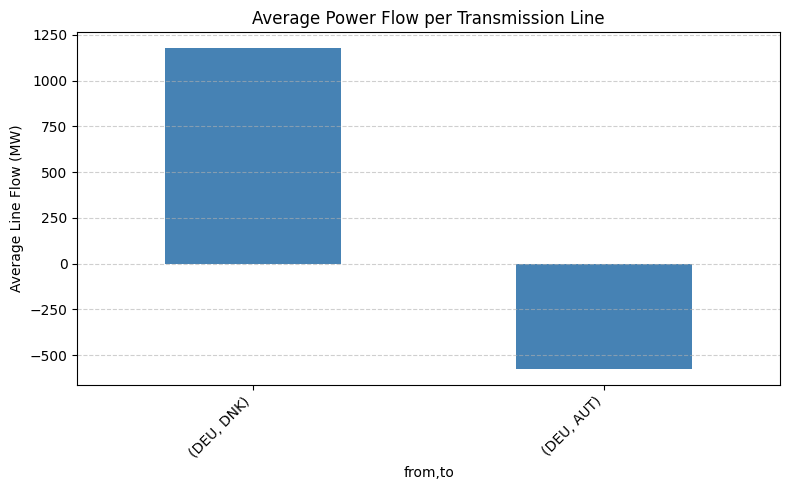

In [162]:
# Create a summary DataFrame
line_flows = pd.DataFrame(index=n.lines.index)
line_flows["from"] = n.lines.bus0
line_flows["to"] = n.lines.bus1
line_flows["average_flow_MW"] = n.lines_t.p0.mean()

# Plot as bar chart
plt.figure(figsize=(8, 5))
line_flows.set_index(["from", "to"])["average_flow_MW"].plot(kind='bar', color='steelblue')
plt.ylabel("Average Line Flow (MW)")
plt.title("Average Power Flow per Transmission Line")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

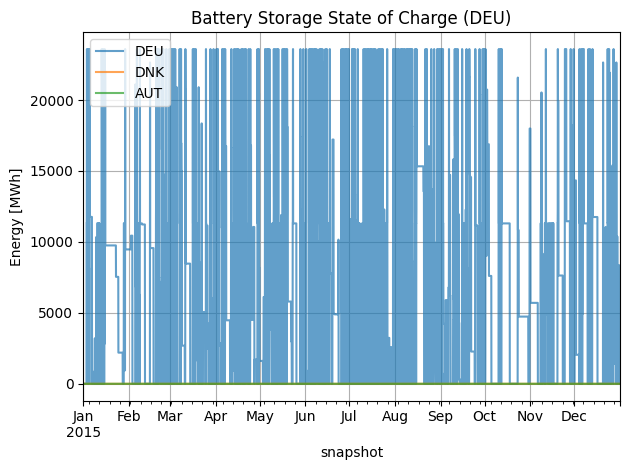

In [168]:
for country in countries:
    name = f"battery{country}"
    if name in n.storage_units_t.state_of_charge:
        n.storage_units_t.state_of_charge[name].plot(label=country, alpha=0.7)
plt.title("Battery Storage State of Charge (DEU)")
plt.ylabel("Energy [MWh]")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


In [174]:
n.stores.e_nom_opt['H2_tank_DEU']

650327.8224343078

Text(0, 0.5, 'Installed Capacity [MW]')

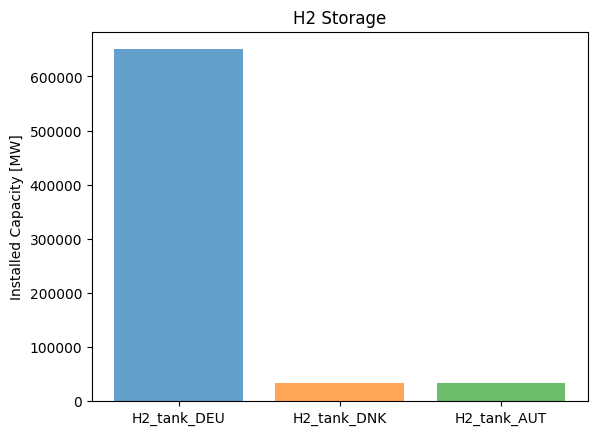

In [177]:
for country in countries:
    name = f"H2_tank_{country}"
    # bar plot of the state of charge
    plt.bar(name, 
            n.stores.e_nom_opt[name], label=country, alpha=0.7)
plt.title("H2 Storage")
plt.ylabel("Installed Capacity [MW]")
